In [1]:
# importing all packages
import pandas as pd
import gzip
import re
from urllib.parse import urlparse, parse_qsl, unquote
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import numpy as np
import datetime 
%matplotlib inline

In [2]:
%pip install google-cloud-bigquery
%pip install pandas-gbq

# Authenticate to GCP in the shell, like this:
# gcloud auth application-default login

from google.cloud import bigquery
from pandas.io import gbq

# Set up BigQuery client
project_id = 'ucb-datahub-2018'
client = bigquery.Client(project=project_id)

# Define SQL query
# replace the FROM... with the BigQuery table you want to query
query = """
SELECT *
FROM `ucb-datahub-2018.datahub_su24.stderr_*`
"""

# Execute query and load data into DataFrame
nbgitpuller_df = gbq.read_gbq(query, project_id=project_id)

nbgitpuller_df.head()



,insertId,labels,logName,receiveTimestamp,resource,severity,textPayload,timestamp
0,zfcnwk0zwtv1iq25,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2023-01-01T00:01:21.752824112Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2023-01-01 00:01:18.743 JupyterHub log:186]...,2023-01-01 00:01:18.744083889+00:00
1,z7c104em5irpurin,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2023-01-01T00:07:09.570118943Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2023-01-01 00:07:08.123 JupyterHub log:186]...,2023-01-01 00:07:08.123614954+00:00
2,3a8drkn15kv63vcy,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2023-01-01T00:07:09.570118943Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2023-01-01 00:07:09.177 JupyterHub log:186]...,2023-01-01 00:07:09.177935010+00:00
3,473ix0agod0y0uyx,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2023-01-01T00:07:49.571954687Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2023-01-01 00:07:44.794 JupyterHub log:186]...,2023-01-01 00:07:44.794346370+00:00
4,v8xyt3k2ovdxxaz4,{'compute.googleapis.com/resource_name': 'gke-...,projects/ucb-datahub-2018/logs/stderr,2023-01-01T00:09:46.721741684Z,"{'labels': {'cluster_name': 'fall-2019', 'cont...",ERROR,[I 2023-01-01 00:09:43.333 JupyterHub log:186]...,2023-01-01 00:09:43.333464197+00:00


# All File Types

In [3]:
# obtaining substring after GET and before the redirection
urls_all = nbgitpuller_df.textPayload.apply(lambda x: x[x.find('GET')+3:x.find('->')].strip())

# uses urllib.parse to parse the url into path and query
urls_parsed_all = urls_all.apply(lambda x: urlparse(x))

# uses the parsed urls to obtain the action from the path
nbgitpuller_df['actions'] = urls_parsed_all.apply(lambda x: os.path.basename(x.path))

In [4]:
nbgitpuller_df.actions.unique()

array(['git-pull', 'git-sync', 'interact'], dtype=object)

## For git-pull

In [5]:
# function to determine the filetypes
def path_extension_puller(row):
    """
    pandas row function; uses apply
    function to pull out select file extensions and urlpaths
    """
    row_dict = dict(row)
    if 'urlpath' in row_dict:
        key = 'urlpath'
    elif 'subPath' in row_dict:
        key = 'subPath'
    else: 
        return 'NaN', 'NaN'
    
    # files that the analysis is interested in 
    file_extension_list = ['ipyn[b]?', 'Rmd', 'pdf', 'txt', 'xml', 'ini', 'csv', 'py', 'R', 'md']
    if len(row_dict[key].split('.')) > 1:
        file_extension_split_string = row_dict[key].split('.')[-1]
        for file_extension in file_extension_list:
            if (len(re.findall(file_extension, file_extension_split_string)) > 0):
                return row_dict[key], re.findall(file_extension, file_extension_split_string)[-1]
        else:
            return row_dict[key], 'NaN'
    else:
            return row_dict[key], 'NaN'

def get_repo(row):
    """
    pandas row function; uses apply
    returns repo url from parsed url
    """
    for item in row:
        key, value = item
        if 'repo' in key:
            return unquote(value)
    return 'NaN'

def repo_parsing(row):
    """
    pandas row function; uses apply
    parses the repo url so that it obtains the user and folder/content user is accessing
    """
    if row:
        if len(row[0].split('/')) > 2:
            return row[0].split('/')[1]
        else:
            return row[0].split('/')[-1]
    else:
        return 'NaN'

In [6]:
# makes a new dataframe that only contains git-pull and resets index
nbgitpuller_df_pull = nbgitpuller_df[nbgitpuller_df.actions == 'git-pull'].reset_index()

# obtains all the log info
log_info_pull = nbgitpuller_df_pull.textPayload.apply(lambda x: ''.join(re.findall("\[.*\]", x)).replace('[', '').replace(']', '').split(' '))

# retreives the hubs for each textpayload
hub_source_pull = nbgitpuller_df_pull.resource.apply(lambda x: x['labels']['namespace_name'])

# obtains substring after GET and before the redirection
urls_pull = nbgitpuller_df_pull.textPayload.apply(lambda x: x[x.find('GET')+3:x.find('->')].strip())

# uses urllib.parse to parse the url into path and query
urls_parsed_pull = urls_pull.apply(lambda x: urlparse(x))

# uses parsed urls to obtain the action as a quality check
actions_pull = urls_parsed_pull.apply(lambda x: os.path.basename(x.path))

# breaks apart the parsed query into repo/urlpath
urls_queries_pull = urls_parsed_pull.apply(lambda x: parse_qsl(x.query))

# getting the file type from urlpath
path_extension_pull = urls_queries_pull.apply(path_extension_puller)

# gets repo urls from the parsed url
repos_pull = urls_queries_pull.apply(get_repo)

# extract ones that have github.com in the repo url or else its a null value
repos_parsed_pull = repos_pull.apply(lambda x: re.findall("github\.com/+(.+)", x) if x else 'NaN')

# obtains the user and git content from github.com repo urls
git_user_pull = repos_parsed_pull.apply(lambda x: x[0].split('/')[0] if x else 'NaN')
git_user_repo_pull = repos_parsed_pull.apply(repo_parsing)

# adds it all into a dataframe
nbgitpuller_textPayload_df_pull = pd.DataFrame({'log_info_type': log_info_pull.apply(lambda x: x[0]),
                                           'timestamp_date': log_info_pull.apply(lambda x: x[1]),
                                           'timestamp_time': log_info_pull.apply(lambda x: x[2]),
                                           'action': actions_pull,
                                           'git_query': urls_queries_pull,
                                           'repo': repos_pull,
                                           'git_user_content': repos_parsed_pull,
                                           'git_user': git_user_pull,
                                           'git_content': git_user_repo_pull,
                                           'git_path': path_extension_pull.apply(lambda x: x[0]),
                                           'file_extension': path_extension_pull.apply(lambda x: x[1]),
                                           'hub': hub_source_pull})

In [7]:
nbgitpuller_textPayload_df_pull['git_user_content_path'] = nbgitpuller_textPayload_df_pull.apply(lambda x: ''.join(x['git_user_content']) + '/' + ''.join(x['git_path']), axis = 1)


In [8]:
def course_assigner_regex(row):
    """
    pandas row function; uses apply
    determines which classes and semesters are for each github repo
    """
    courses = {'(data8|ds8)': 'data8', '(ds100|data100)': 'data100', '(prob140)': 'data140', #data
               '(caldataeng|data101|ds101)': 'data101', '(data6|ds6)': 'data6', '(data102|ds102)': 'data102', #data
               '(data4ac|ds4ac)': 'data4ac', '(data198|ds198)': 'data198',
               '(cs189|compsci189)': 'compsci189', '(cs170|compsci170)': 'compsci170', #compsci 
               '(ee16a|eecs16a)': 'eecs16a', '(ee16b|eecs16b)': 'eecs16b', '(eecs127)': 'eecs127',#eecs
               '(ee120|eleng120)': 'eleng120', #electrical engineering
               '(physics111b)': 'physics111b', '(physics88)': 'physics88', # physics
               '(polsci3|ps3|polisci3)': 'polsci3', '(polsci5|ps5)': 'polsci5', '(polsci88|ps88)': 'polsci88', '(ps109|polsci109)': 'polsci109', # polisci
               '(ce190|civeng90)': 'civgeng190', '(ce93|civeng93)': 'civeng93', '(ce200b|civeng200b)': 'civeng200b', '(ce110|civeng110)': 'civeng110', #civileng
               '(envecon118|eep118)': 'envecon118', '(eep147|envecon147)': 'envecon147', '(eep153|envecon153)': 'envecon153', #environmental
               'ph[w]?142': 'pbhlth142', 'ph[w]?251': 'pbhlth251', 'ph[w]?290': 'pbhlth290', 'ph[w]?252': 'pbhlth252', 'ph[w]?253': 'pbhlth253', 'pbhlth250c': 'pbhlth250c',
               'ph[w]?196': 'pbhlth196', # public health
               'mcb163l': 'mcellbi163l', 'mcb280': 'mcellbi280', 'mcbc117': 'mcellbic117', 'mcb32': 'mcellbi32', 'mcb288': 'mcellbi288', #molecular cell bio
               '(bio1b|biology1b)': 'biology1b', # biology
               'stat88': 'stat88', 'stat157': 'stat157', 'stat159': 'stat159', 'stat131': 'stat131', 'stat135': 'stat135', 'stat20': 'stat20', 
               'stat150': 'stat150', #stat
               'math124': 'math124', #math
               '(demog180)': 'demog180', 'demog[c]?175': 'demog175', #demography
               '(eps130)': 'eps130', '(eps88)': 'eps88', 'eps256': 'eps256', 'eps24': 'eps24',
               '(econ140)': 'econ140', '(econ148)': 'econ148', 'econ141': 'econ141', 'econ172': 'econ172', 'econ151': 'econ151', #econ
               'econ157': 'econ157', 'econ130': 'econ130', 'econ143': 'econ143', 'econ135': 'econ135',
               '(rbridge)': 'datasci_rbridge', '(midsw241)': 'datasci241', '(midsw203)': 'datasci203', #datasci
               '(legal123|legalst123)': 'legalst123', '(legalst190|legal190)': 'legalst190', # legal
               '(es22ac|ethstd22ac)': 'ethstd22ac', '(esc164a|ethstdc164a)': 'ethstdc164a', '(es21ac|ethstd21ac)': 'ethstd21ac',  # ethnic studies
               'cp201b': 'cyplan201b', '(cityplanning88|cp88)': 'cyplan88', 
               'ib120': 'integbi120', 'ibc32': 'integbi32', 'ib134l': 'integbi134l',
               'mse104l': 'matsci104l',
               'are212': 'aresec212',
               'educw142': 'educw142',
               '(cogscic131|psych123)': 'cogscic131', 'psych198': 'psych198',
               'anth[ro]?115': 'anthro115',
               'espmc167': 'espmc167', '(ibespm105)': 'espmc105',
               'ls88': 'ls88',
               'dighum101': 'dighum101', 'dighum160': 'dighum160',
               'plantbi135': 'plantbi135',
               'hist160': 'history160',
               'soc88': 'sociol88', 'sw282': 'socwel282',
               'music30': 'music30', 'artw23ac': 'artw23ac'} 
    # hard coded
    git_content_user = {'danielabrahamgit120': 'eleng120', 'evalencialopezw142': 'educw142', 'charismasacey[A-Za-z0-9]+cp201': 'cp201a'}

    #strips anything thats not a letter or number
    git_string_cleaned = re.sub(r'[^a-zA-Z0-9]', '', ''.join(row)).lower()
    for key in courses:
        if re.findall(key, git_string_cleaned):
            return courses[key]
    for key in git_content_user:
        if re.findall(key, git_string_cleaned):
            return git_content_user[key]
    else:
        return 'unknown'
    

In [9]:
# assigns classes/courses to each log
nbgitpuller_textPayload_df_pull['course'] = nbgitpuller_textPayload_df_pull.git_user_content_path.apply(course_assigner_regex)

In [10]:
def semester_assigner_regex(row):
    """
    pandas row function; uses apply
    returns the semester of the course material if known
    """
    semester = ['fa[ll]*\d{1,4}', 'su[mmer]*\d{1,4}', 'sp[ring]*\d{1,4}', '\d{1,4}+fa[ll]', '\d{1,4}+su[mmer]*', '\d{1,4}+sp[ring]*']
    sem_match_dict = {'sp': 'spring', 'fa': 'fall', 'su':'summer'}

    git_string_cleaned = re.sub(r'[^a-zA-Z0-9]', '', ''.join(row)).lower()

    year_range = [2018, datetime.datetime.now().year]

    for sem in semester:
        if re.findall(sem, git_string_cleaned):
            sem_match = re.findall(sem, git_string_cleaned)[-1]
            sem_match_split = re.split('(\d+)', sem_match)
            sem_char = re.findall('[a-z]+', sem_match)[-1]
            sem_year = re.findall('[0-9]+', sem_match)[-1]
            for key, value in sem_match_dict.items():
                if key in sem_char and sem_match_split[-1] == '':
                    if len(sem_year) < 4:
                        if year_range[0] <= int(f'20{sem_year[-2:]}') <= year_range[1]:
                            return f'{value}20{sem_year[-2:]}'
                        else:
                            return 
                    elif len(sem_year) == 4:
                        if year_range[0] <= int(sem_year) <= year_range[1]:
                            return f'{value}{sem_year}'
                        else:
                            return 'unknown'
                elif key in sem_char and sem_match_split[-1] != '':
                    if year_range[0] <= int(sem_year) <= year_range[1]:
                        return f'{value}{sem_year}'
                    else:
                        return 'unknown'
    else:
        return 'unknown'


In [11]:
# assigns a semester to each log
nbgitpuller_textPayload_df_pull['semester'] = nbgitpuller_textPayload_df_pull.git_user_content_path.apply(semester_assigner_regex)

In [12]:
# transforms timestamp into one and converts from UTC to PST
nbgitpuller_textPayload_df_pull['timestamp_date_time_pst'] = pd.to_datetime(nbgitpuller_textPayload_df_pull.timestamp_date + ' ' + nbgitpuller_textPayload_df_pull.timestamp_time) - pd.Timedelta(8, unit = 'h')

In [13]:
# for ones that have NaN as their filetype, check if git_path contains r_studio
nbgitpuller_textPayload_df_pull['file_extension'] = nbgitpuller_textPayload_df_pull.apply(lambda x: 'rstudio' if 'rstudio' in x['git_path'] else x['file_extension'], axis = 1)

In [14]:
# determines if the links are github or non-github
nbgitpuller_textPayload_df_pull['abnormal'] = nbgitpuller_textPayload_df_pull.repo.apply(lambda x: 'N' if 'github.com' in x else 'Y')

In [15]:
nbgitpuller_textPayload_df_pull.head()

,log_info_type,timestamp_date,timestamp_time,action,git_query,repo,git_user_content,git_user,git_content,git_path,file_extension,hub,git_user_content_path,course,semester,timestamp_date_time_pst,abnormal
0,I,2023-01-01,00:01:18.743,git-pull,"[(repo, https://github.com/data-8/materials-fa...",https://github.com/data-8/materials-fa22,[data-8/materials-fa22],data-8,materials-fa22,retro/tree/materials-fa22/materials/fa22/lab/l...,ipynb,data8-prod,data-8/materials-fa22/retro/tree/materials-fa2...,data8,fall2022,2022-12-31 16:01:18.743,N
1,I,2023-01-01,00:07:08.123,git-pull,"[(repo, https://github.com/DS-100/fa22), (bran...",https://github.com/DS-100/fa22,[DS-100/fa22],DS-100,fa22,lab/tree/fa22/proj/proj1b/proj1b.ipynb,ipynb,data100-prod,DS-100/fa22/lab/tree/fa22/proj/proj1b/proj1b.i...,data100,fall2022,2022-12-31 16:07:08.123,N
2,I,2023-01-01,00:07:09.177,git-pull,"[(repo, https://github.com/DS-100/fa22), (bran...",https://github.com/DS-100/fa22,[DS-100/fa22],DS-100,fa22,lab/tree/fa22/proj/proj1a/proj1a.ipynb,ipynb,data100-prod,DS-100/fa22/lab/tree/fa22/proj/proj1a/proj1a.i...,data100,fall2022,2022-12-31 16:07:09.177,N
3,I,2023-01-01,00:07:44.794,git-pull,"[(repo, https://github.com/DS-100/fa22), (bran...",https://github.com/DS-100/fa22,[DS-100/fa22],DS-100,fa22,lab/tree/fa22/proj/proj1a/proj1a.ipynb,ipynb,data100-prod,DS-100/fa22/lab/tree/fa22/proj/proj1a/proj1a.i...,data100,fall2022,2022-12-31 16:07:44.794,N
4,I,2023-01-01,00:09:43.333,git-pull,"[(repo, https://github.com/BerkeleyML/cs189-no...",https://github.com/BerkeleyML/cs189-notebooks,[BerkeleyML/cs189-notebooks],BerkeleyML,cs189-notebooks,tree/cs189-notebooks/hw7,NaN,datahub-prod,BerkeleyML/cs189-notebooks/tree/cs189-notebook...,compsci189,unknown,2022-12-31 16:09:43.333,N


In [16]:
# separates abnormal repos 
nbgitpuller_textPayload_df_pull_abnormal = nbgitpuller_textPayload_df_pull[nbgitpuller_textPayload_df_pull.abnormal == 'Y']
nbgitpuller_textPayload_df_pull_normal = nbgitpuller_textPayload_df_pull[nbgitpuller_textPayload_df_pull.abnormal == 'N']

## Graph and Visualizations

### Ideas for Visualizations
1. Clicks by hub
2. What times people are accessing the hubs
3. File types across hubs
4. Semester usage of hubs

### Github Repos

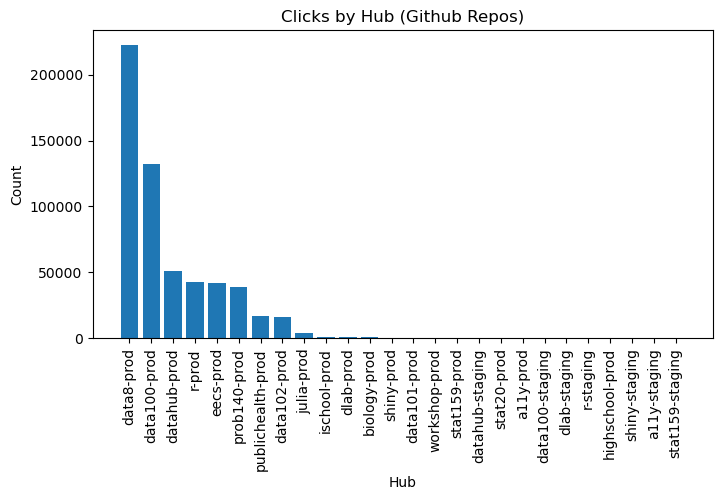

In [19]:
# clicks by hub for normal
clicks_by_hub = nbgitpuller_textPayload_df_pull_normal.hub.value_counts()
fig = plt.figure(figsize = (8,4))
plt.bar(clicks_by_hub.index, clicks_by_hub)
plt.xlabel('Hub')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Clicks by Hub (Github Repos)');

Text(0.5, 1.0, 'Clicks By Hub (Percentage) - Github Repos')

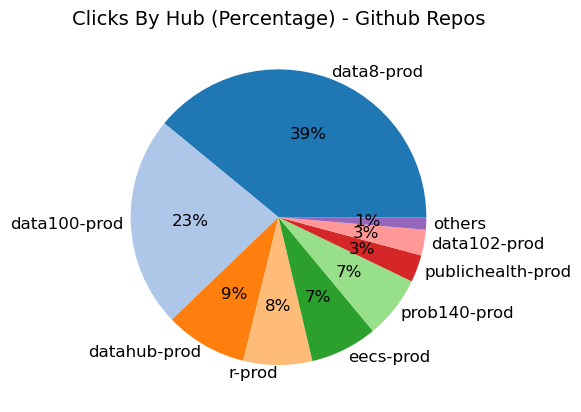

In [46]:
# clicks by hub pie chart
# only take the top 8 and then add the rest
clicks_by_hub_top8 = dict(clicks_by_hub[:8])
fig = plt.figure()
cm = plt.get_cmap('tab20')
num_colors = 9
clicks_by_hub_top8['others'] = clicks_by_hub[8:].sum()
clicks_by_hub_top8_df = pd.DataFrame(clicks_by_hub_top8.items(), columns = ['hub', 'counts'])
plt.pie(clicks_by_hub_top8_df.counts, labels = clicks_by_hub_top8_df.hub, autopct='%1.0f%%', textprops={'fontsize': 12, 'color': 'k'}, labeldistance= 1.05, colors= [cm(i) for i in range(num_colors)])
plt.title('Clicks By Hub (Percentage) - Github Repos', fontsize = 14, color = 'k')


In [45]:
fig.savefig("../images/hub_pie.png", transparent = True)

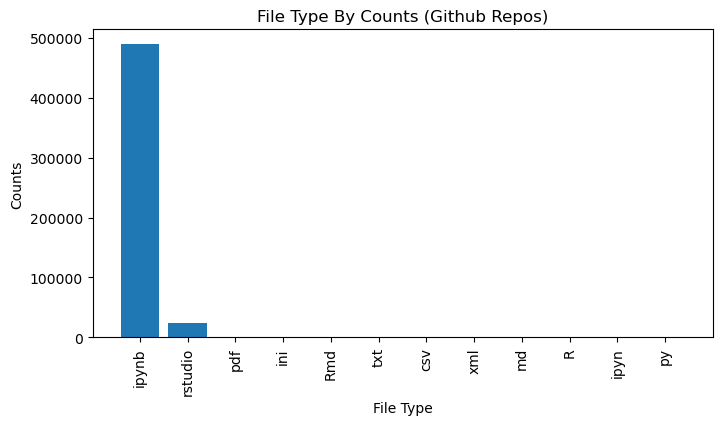

In [22]:
# filetypes; removed NaN counts; github repos
file_types_count = nbgitpuller_textPayload_df_pull_normal.file_extension[nbgitpuller_textPayload_df_pull_normal.file_extension != 'NaN'].value_counts()
fig = plt.figure(figsize=(8,4))
plt.bar(file_types_count.index, file_types_count)
plt.xticks(rotation=90)
plt.xlabel('File Type')
plt.ylabel('Counts')
plt.title('File Type By Counts (Github Repos)');

In [23]:
# filetypes across hubs
hubs = nbgitpuller_textPayload_df_pull_normal.hub.unique()
total_plots = len(hubs)
total_columns = 4
total_rows = math.ceil(total_plots/total_columns)

for k in range(total_plots):
    hub_file_filter_count = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.hub == hubs[k]].file_extension.value_counts().tolist()
    hub_file_filter_proportion = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.hub == hubs[k]].file_extension.value_counts(normalize = True).mul(100).round(2).tolist()
    hub_file_filter_key = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.hub == hubs[k]].file_extension.value_counts().keys().tolist()
    hub_file_filter_df = pd.DataFrame(data = {'file_type': hub_file_filter_key, 'counts': hub_file_filter_count, 'proportions': hub_file_filter_proportion})
    hub_file_filter_df['count_proportion'] = hub_file_filter_df['counts'].astype(str) + ' (' + hub_file_filter_df['proportions'].astype(str) + ')'
    hub_file_filter_df.drop(columns = ['counts', 'proportions'], inplace = True)
    print(hubs[k])
    print(hub_file_filter_df)

# for ax in axes.flatten():
#     if not ax.get_visible():
#         ax.set_axis_off()

data8-prod
  file_type count_proportion
0     ipynb   222321 (99.84)
1       NaN       239 (0.11)
2       ini        94 (0.04)
3       txt        12 (0.01)
4       xml          8 (0.0)
data100-prod
  file_type count_proportion
0     ipynb   128077 (97.09)
1       NaN      3728 (2.83)
2       ini        94 (0.07)
3       txt        12 (0.01)
4       xml         8 (0.01)
5         R          1 (0.0)
datahub-prod
   file_type count_proportion
0      ipynb    42561 (82.97)
1        NaN      4946 (9.64)
2    rstudio      3146 (6.13)
3        Rmd       324 (0.63)
4        pdf       148 (0.29)
5        ini        94 (0.18)
6        csv        41 (0.08)
7         md        16 (0.03)
8        txt        12 (0.02)
9        xml         8 (0.02)
10        py          1 (0.0)
prob140-prod
  file_type count_proportion
0     ipynb    38896 (99.93)
1       NaN        29 (0.07)
ischool-prod
  file_type count_proportion
0   rstudio     1218 (100.0)
eecs-prod
  file_type count_proportion
0       NaN     

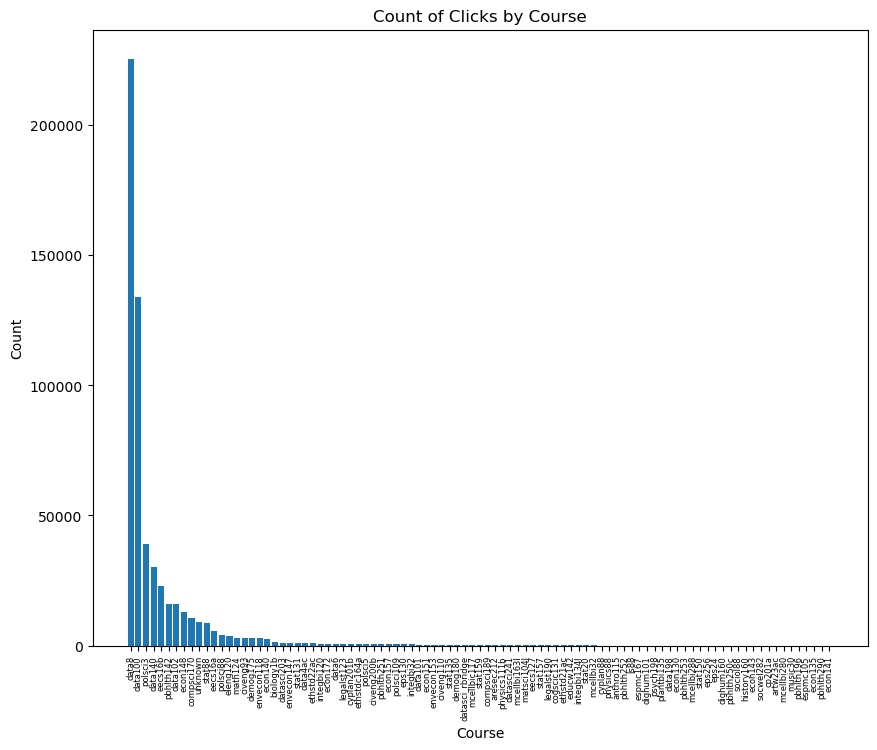

In [24]:
# looking at the classes
course_count = nbgitpuller_textPayload_df_pull_normal.course.value_counts()
figure = plt.figure(figsize = (10,8))
plt.bar(course_count.index, course_count)
plt.xticks(rotation = 90, fontsize = 6)
plt.xlabel('Course')
plt.ylabel('Count')
plt.title('Count of Clicks by Course');

In [25]:
# top 10 of the courses
course_count.head(10)

course
data8         225371
data100       133987
polsci3        39160
data140        30271
eecs16b        22837
pbhlth142      16161
data102        16023
econ148        12791
compsci170     10539
unknown         8934
Name: count, dtype: int64

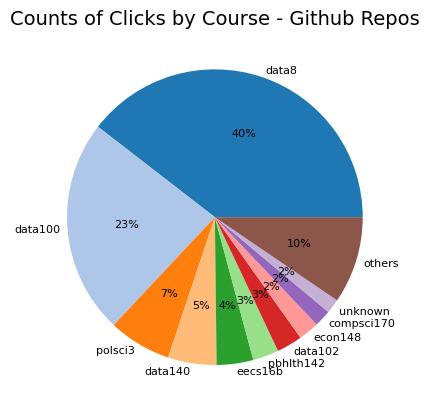

In [59]:
fig = plt.figure()
num_colors = 11
cm = plt.get_cmap('tab20')
courses_top10 = dict(course_count[:10])
courses_top10['others'] = course_count[10:].sum()
courses_top10_df = pd.DataFrame(courses_top10.items(), columns = ['course', 'counts'])
plt.pie(courses_top10_df.counts, labels = courses_top10_df.course, autopct='%1.0f%%', textprops={'fontsize': 8}, labeldistance= 1.05, 
        colors= [cm(i) for i in range(num_colors)])
plt.title('Counts of Clicks by Course - Github Repos', fontsize = 14);

In [58]:
fig.savefig("../images/course_pie.png",bbox_inches='tight', transparent = True)

In [28]:
courses_count_by_hub = nbgitpuller_textPayload_df_pull_normal.groupby('hub').course.value_counts()
courses_count_by_hub.to_csv('courses_count_by_hub.csv')

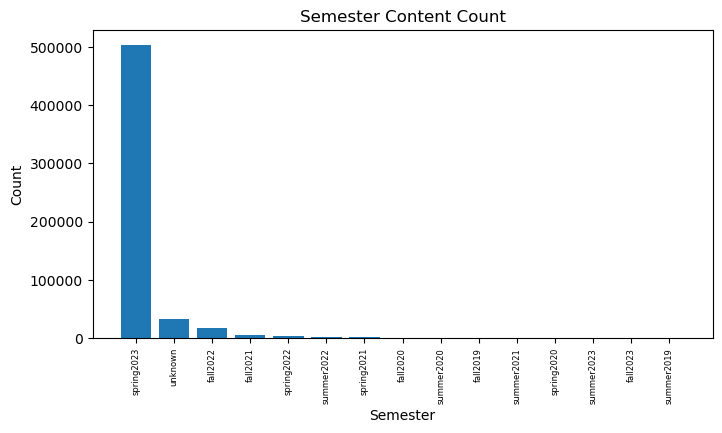

In [29]:
# looking at the semester usage 
sem_count = nbgitpuller_textPayload_df_pull_normal.semester.value_counts()
figure = plt.figure(figsize = (8,4))
plt.bar(sem_count.index, sem_count)
plt.xticks(rotation = 90, fontsize = 6)
plt.xlabel('Semester')
plt.ylabel('Count')
plt.title('Semester Content Count');

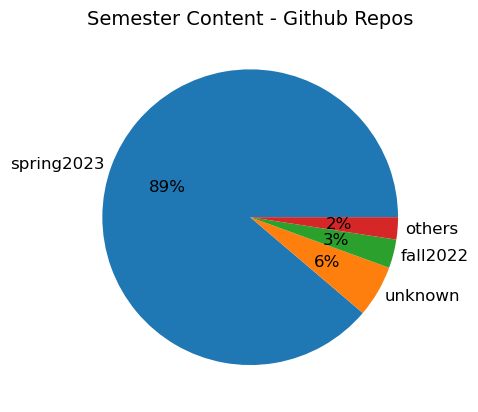

In [38]:
# looking at what times people access the hubs
fig = plt.figure()
num_colors = 4
cm = plt.get_cmap('tab10')
sem_top7 = dict(sem_count[:3])
sem_top7['others'] = sem_count[3:].sum()
sem_top7_df = pd.DataFrame(sem_top7.items(), columns = ['semester', 'counts'])
plt.pie(sem_top7_df.counts, labels = sem_top7_df.semester, autopct='%1.0f%%', textprops={'fontsize': 12}, labeldistance= 1.05, 
        colors= [cm(i) for i in range(num_colors)])
plt.title('Semester Content - Github Repos', fontsize = 14);

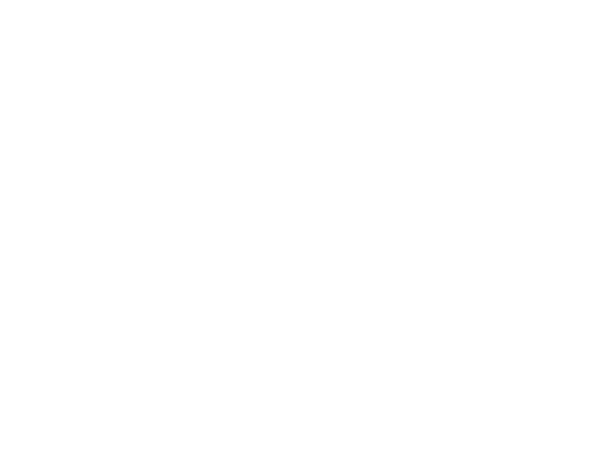

In [109]:
# looks at date of usage
date_usage = pd.DataFrame(nbgitpuller_textPayload_df_pull_normal.groupby(by = 'timestamp_date').timestamp_date.count())
date_usage.rename(columns = {'timestamp_date': 'count'}, inplace = True)
date_usage = date_usage.reset_index()
fig,ax = plt.subplots()
plt.bar(date_usage.timestamp_date, date_usage['count'], color = 'w')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.spines['bottom'].set_color('w')
ax.spines['top'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.tick_params(axis ='x', colors = 'w')
ax.tick_params(axis ='y', colors = 'w')
plt.title('Usage by Date', color = 'w', fontsize = 12)
plt.xlabel('Date', color = 'w', fontsize = 12)
plt.ylabel('Frequency', color = 'w', fontsize = 12);

In [110]:
fig.savefig("../images/usage_bar.png",bbox_inches='tight', transparent = True)

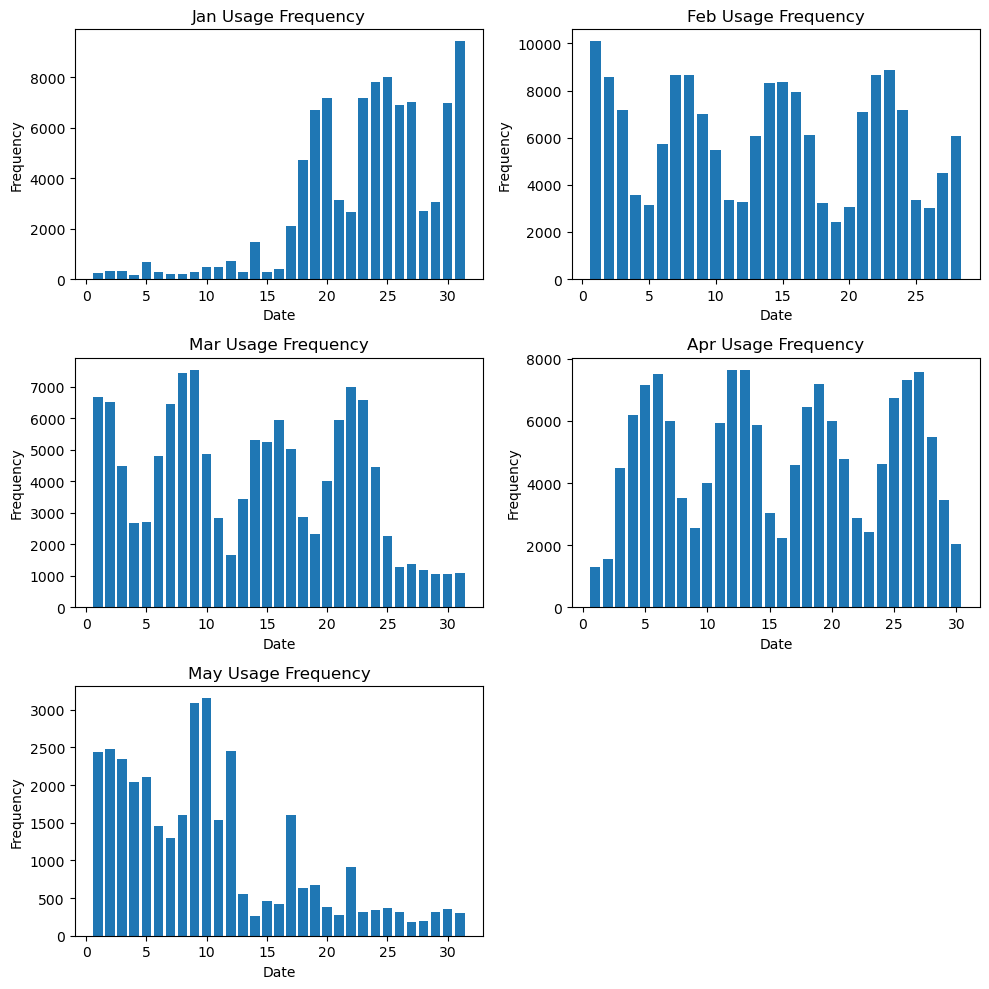

In [28]:
date_usage['timestamp_date'] = date_usage.timestamp_date.astype('datetime64[ns]')
date_usage['month'] = date_usage['timestamp_date'].apply(lambda x: x.month)
date_usage['day'] = date_usage['timestamp_date'].apply(lambda x: x.day)
unique_months = date_usage['month'].unique()
month_list = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

total_plots = len(unique_months)
total_columns = 2
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(10, 10))

for k in range(total_plots):
    month = date_usage[date_usage['month'] == unique_months[k]].reset_index()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(month['day'], month['count'])

    ax.set_title(f'{month_list[unique_months[k]]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')

axes[2,1].set_axis_off()
plt.tight_layout()

In [74]:
nbgitpuller_textPayload_df_pull_normal.head()

,log_info_type,timestamp_date,timestamp_time,action,git_query,repo,git_user_content,git_user,git_content,git_path,file_extension,hub,git_user_content_path,course,semester,timestamp_date_time_pst,abnormal
0,I,2023-01-01,00:01:18.743,git-pull,"[(repo, https://github.com/data-8/materials-fa...",https://github.com/data-8/materials-fa22,[data-8/materials-fa22],data-8,materials-fa22,retro/tree/materials-fa22/materials/fa22/lab/l...,ipynb,data8-prod,data-8/materials-fa22/retro/tree/materials-fa2...,data8,fall2022,2022-12-31 16:01:18.743,N
1,I,2023-01-01,00:07:08.123,git-pull,"[(repo, https://github.com/DS-100/fa22), (bran...",https://github.com/DS-100/fa22,[DS-100/fa22],DS-100,fa22,lab/tree/fa22/proj/proj1b/proj1b.ipynb,ipynb,data100-prod,DS-100/fa22/lab/tree/fa22/proj/proj1b/proj1b.i...,data100,fall2022,2022-12-31 16:07:08.123,N
2,I,2023-01-01,00:07:09.177,git-pull,"[(repo, https://github.com/DS-100/fa22), (bran...",https://github.com/DS-100/fa22,[DS-100/fa22],DS-100,fa22,lab/tree/fa22/proj/proj1a/proj1a.ipynb,ipynb,data100-prod,DS-100/fa22/lab/tree/fa22/proj/proj1a/proj1a.i...,data100,fall2022,2022-12-31 16:07:09.177,N
3,I,2023-01-01,00:07:44.794,git-pull,"[(repo, https://github.com/DS-100/fa22), (bran...",https://github.com/DS-100/fa22,[DS-100/fa22],DS-100,fa22,lab/tree/fa22/proj/proj1a/proj1a.ipynb,ipynb,data100-prod,DS-100/fa22/lab/tree/fa22/proj/proj1a/proj1a.i...,data100,fall2022,2022-12-31 16:07:44.794,N
4,I,2023-01-01,00:09:43.333,git-pull,"[(repo, https://github.com/BerkeleyML/cs189-no...",https://github.com/BerkeleyML/cs189-notebooks,[BerkeleyML/cs189-notebooks],BerkeleyML,cs189-notebooks,tree/cs189-notebooks/hw7,NaN,datahub-prod,BerkeleyML/cs189-notebooks/tree/cs189-notebook...,compsci189,unknown,2022-12-31 16:09:43.333,N


/var/folders/wg/np04l4k14h174_2s7j_7h5kw0000gn/T/ipykernel_1906/2849810792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbgitpuller_textPayload_df_pull_normal['timestamp_time'] = pd.to_datetime(nbgitpuller_textPayload_df_pull_normal['timestamp_time'], format = '%H:%M:%S.%f')
/var/folders/wg/np04l4k14h174_2s7j_7h5kw0000gn/T/ipykernel_1906/2849810792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbgitpuller_textPayload_df_pull_normal['timestamp_time_hour'] = nbgitpuller_textPayload_df_pull_normal

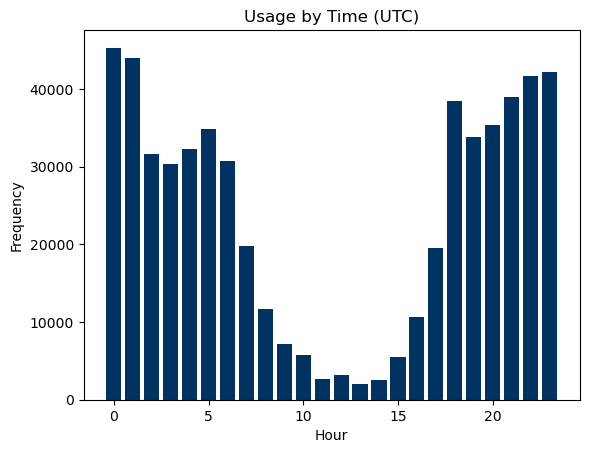

In [94]:
# looks at date of usage
nbgitpuller_textPayload_df_pull_normal['timestamp_time'] = pd.to_datetime(nbgitpuller_textPayload_df_pull_normal['timestamp_time'], format = '%H:%M:%S.%f')
nbgitpuller_textPayload_df_pull_normal['timestamp_time_hour'] = nbgitpuller_textPayload_df_pull_normal['timestamp_time'].apply(lambda x: x.hour)
usage_time = nbgitpuller_textPayload_df_pull_normal.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
usage_time = pd.DataFrame(usage_time)
usage_time.rename(columns = {'timestamp_time_hour': 'count'}, inplace = True)
usage_time = usage_time.reset_index()
fig,ax = plt.subplots()
plt.bar(usage_time.timestamp_time_hour, usage_time['count'], color = '#003262')
ax.spines['bottom'].set_color('k')
ax.spines['top'].set_color('k')
ax.spines['left'].set_color('k')
ax.spines['right'].set_color('k')
ax.tick_params(axis ='x', colors = 'k')
ax.tick_params(axis ='y', colors = 'k')
plt.title('Usage by Time (UTC)', color = 'k')
plt.xlabel('Hour', color = 'k')
plt.ylabel('Frequency', color = 'k');

In [95]:
fig.savefig("../images/time_usage_bar.png",bbox_inches='tight', transparent = True)

##### Making Graphs of Date of Usage Per Course

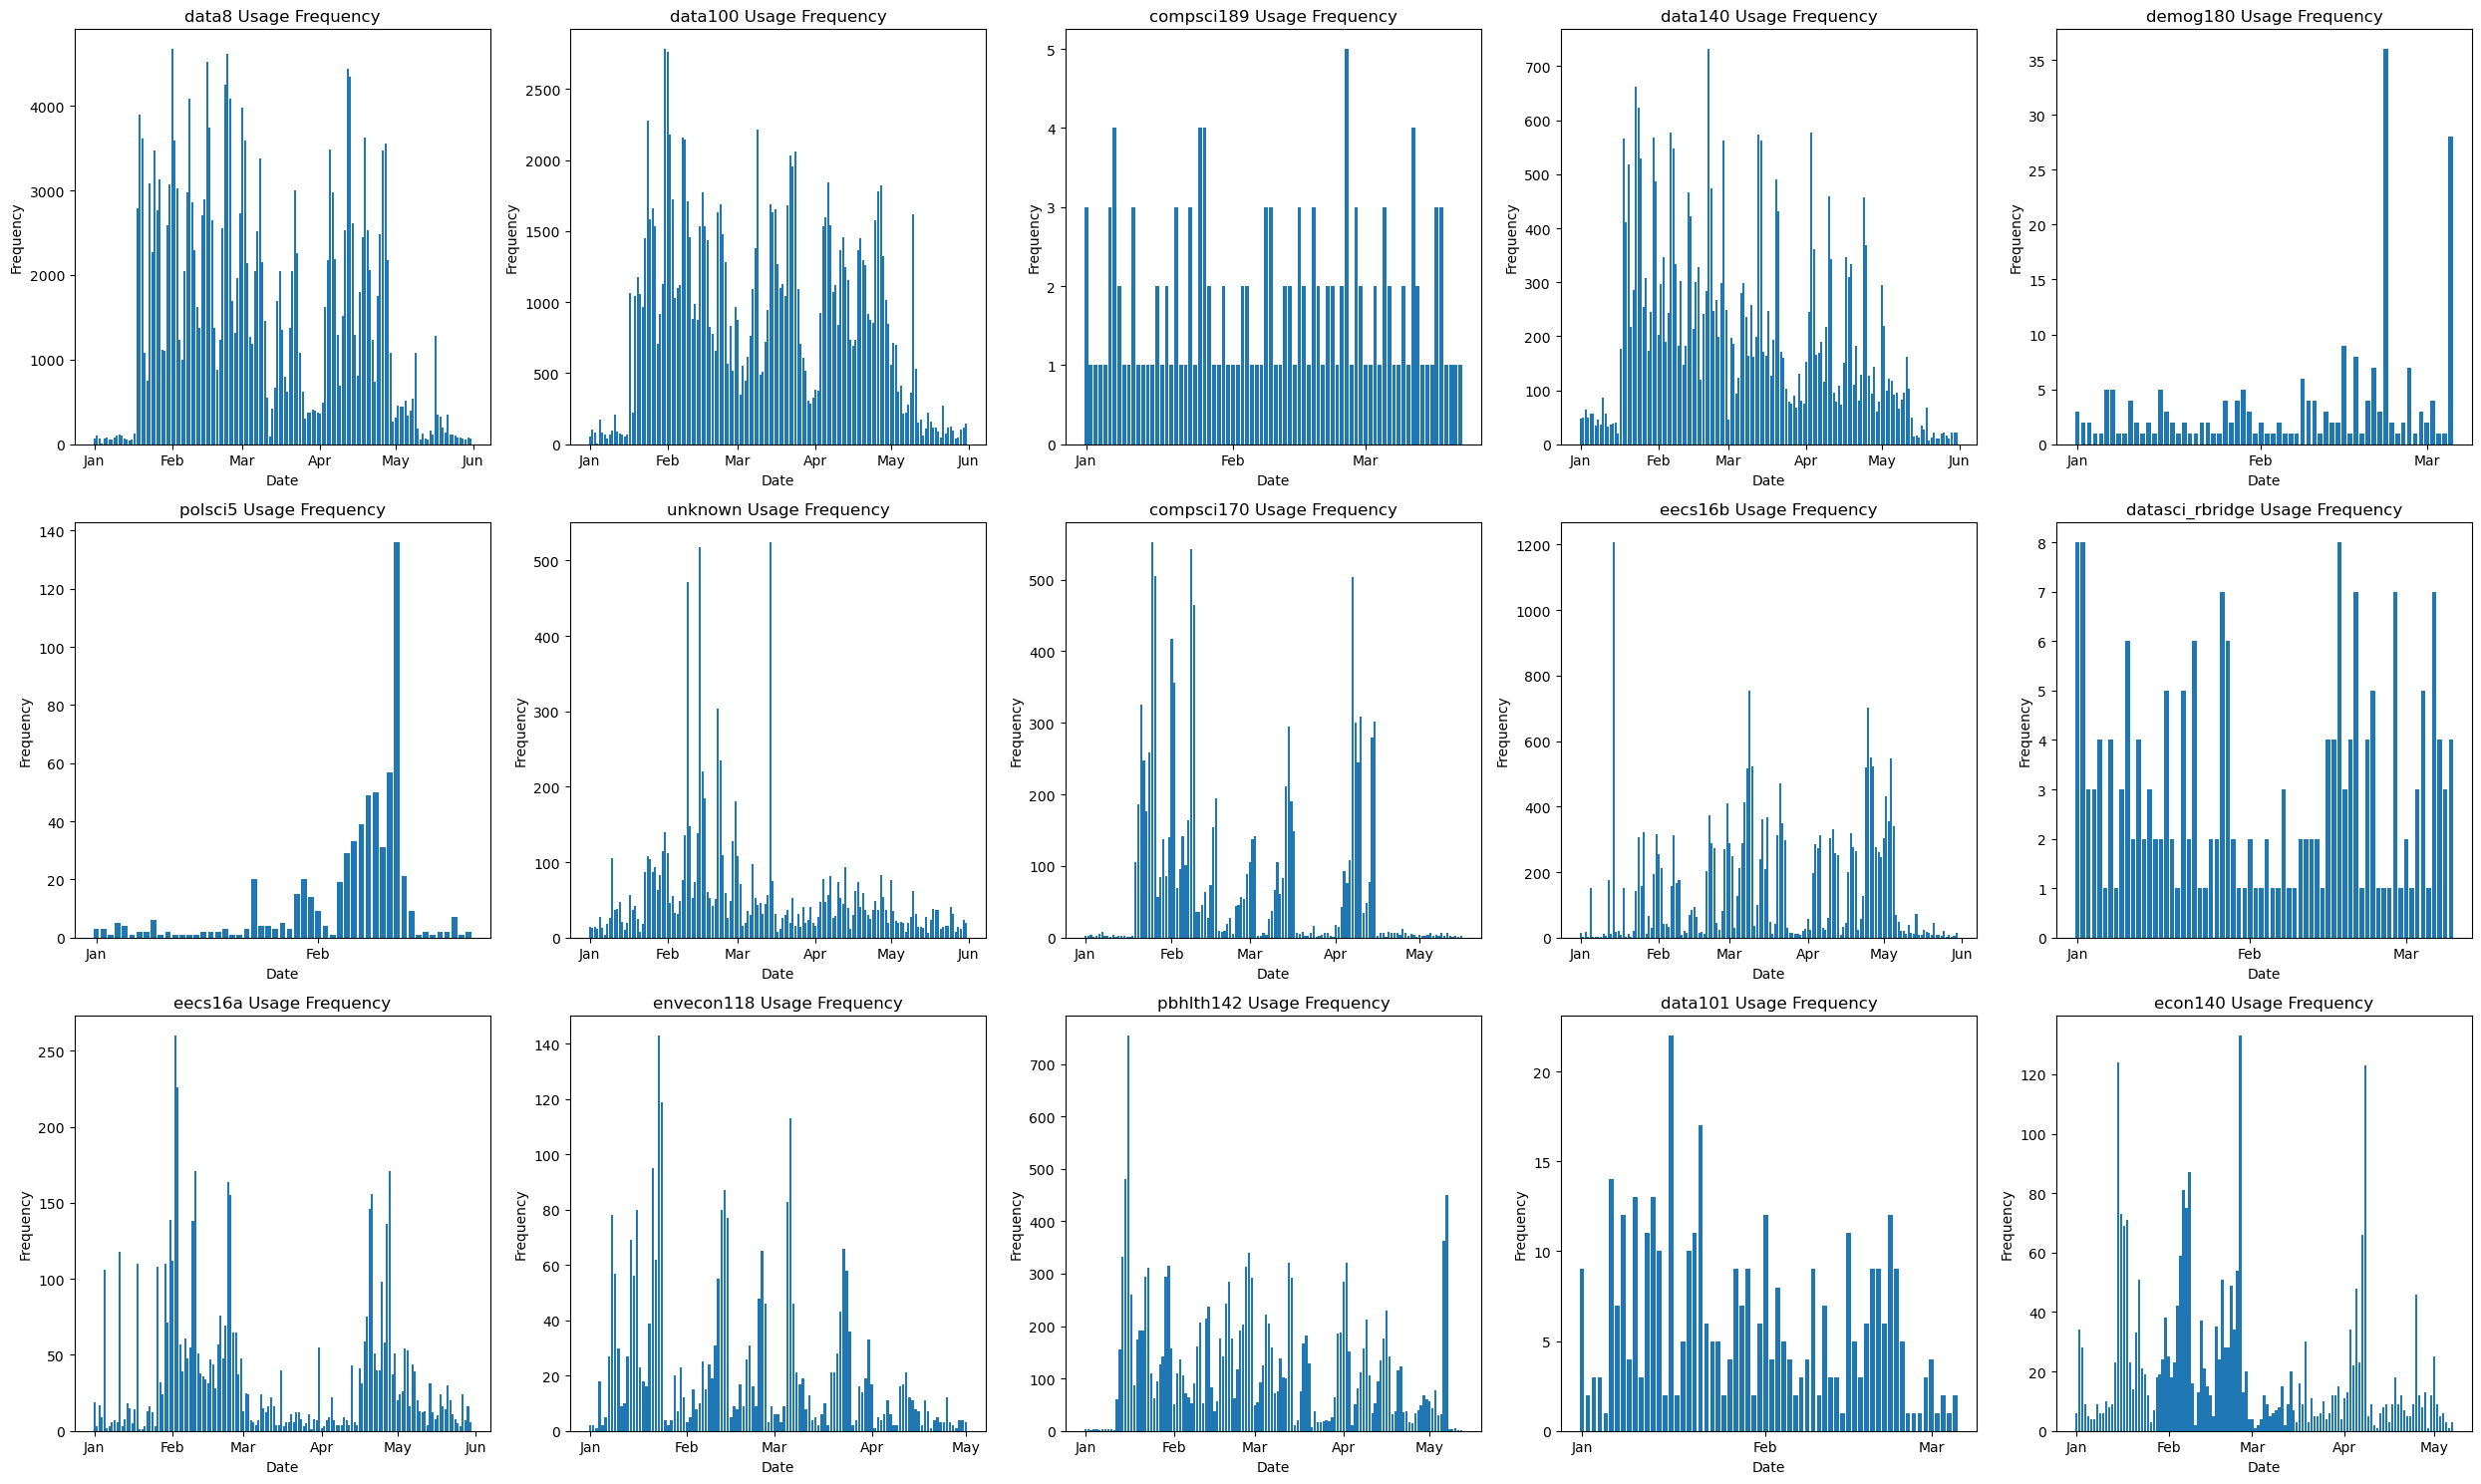

In [29]:
# look at usage by courses 1-15
unique_courses = nbgitpuller_textPayload_df_pull_normal.course.unique()

# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

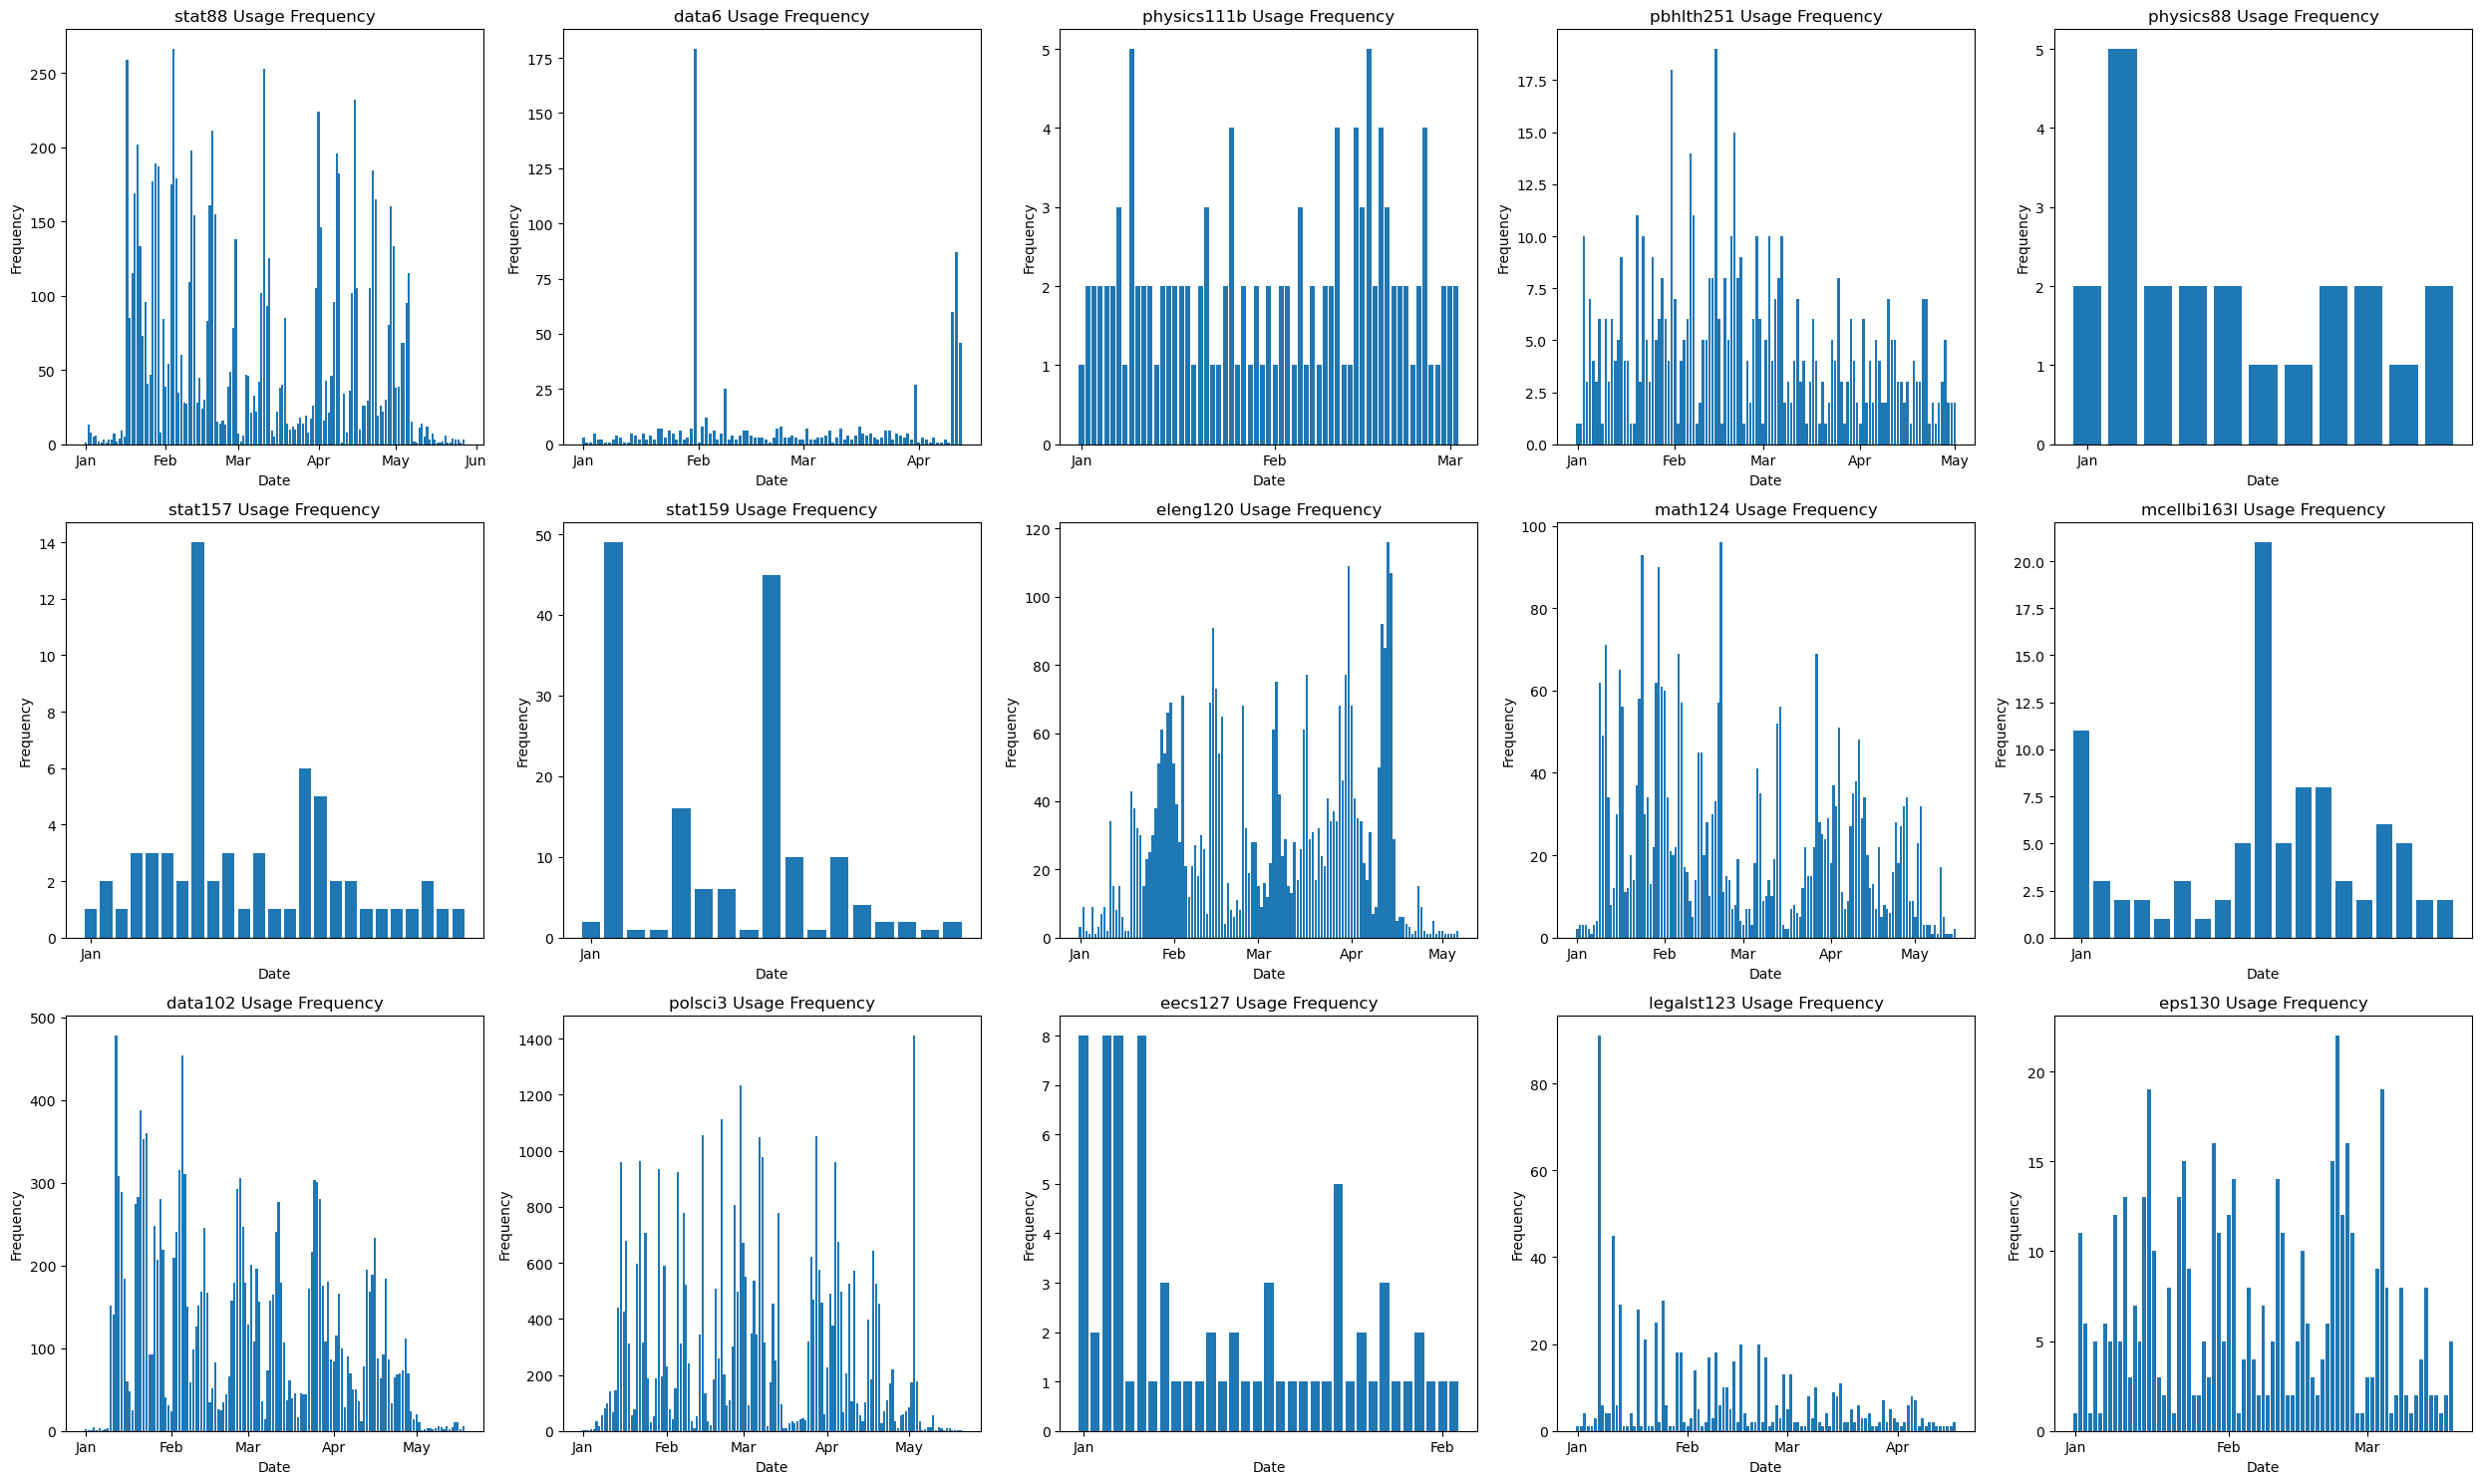

In [30]:
# look at plots 16-30
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+15]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+15]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

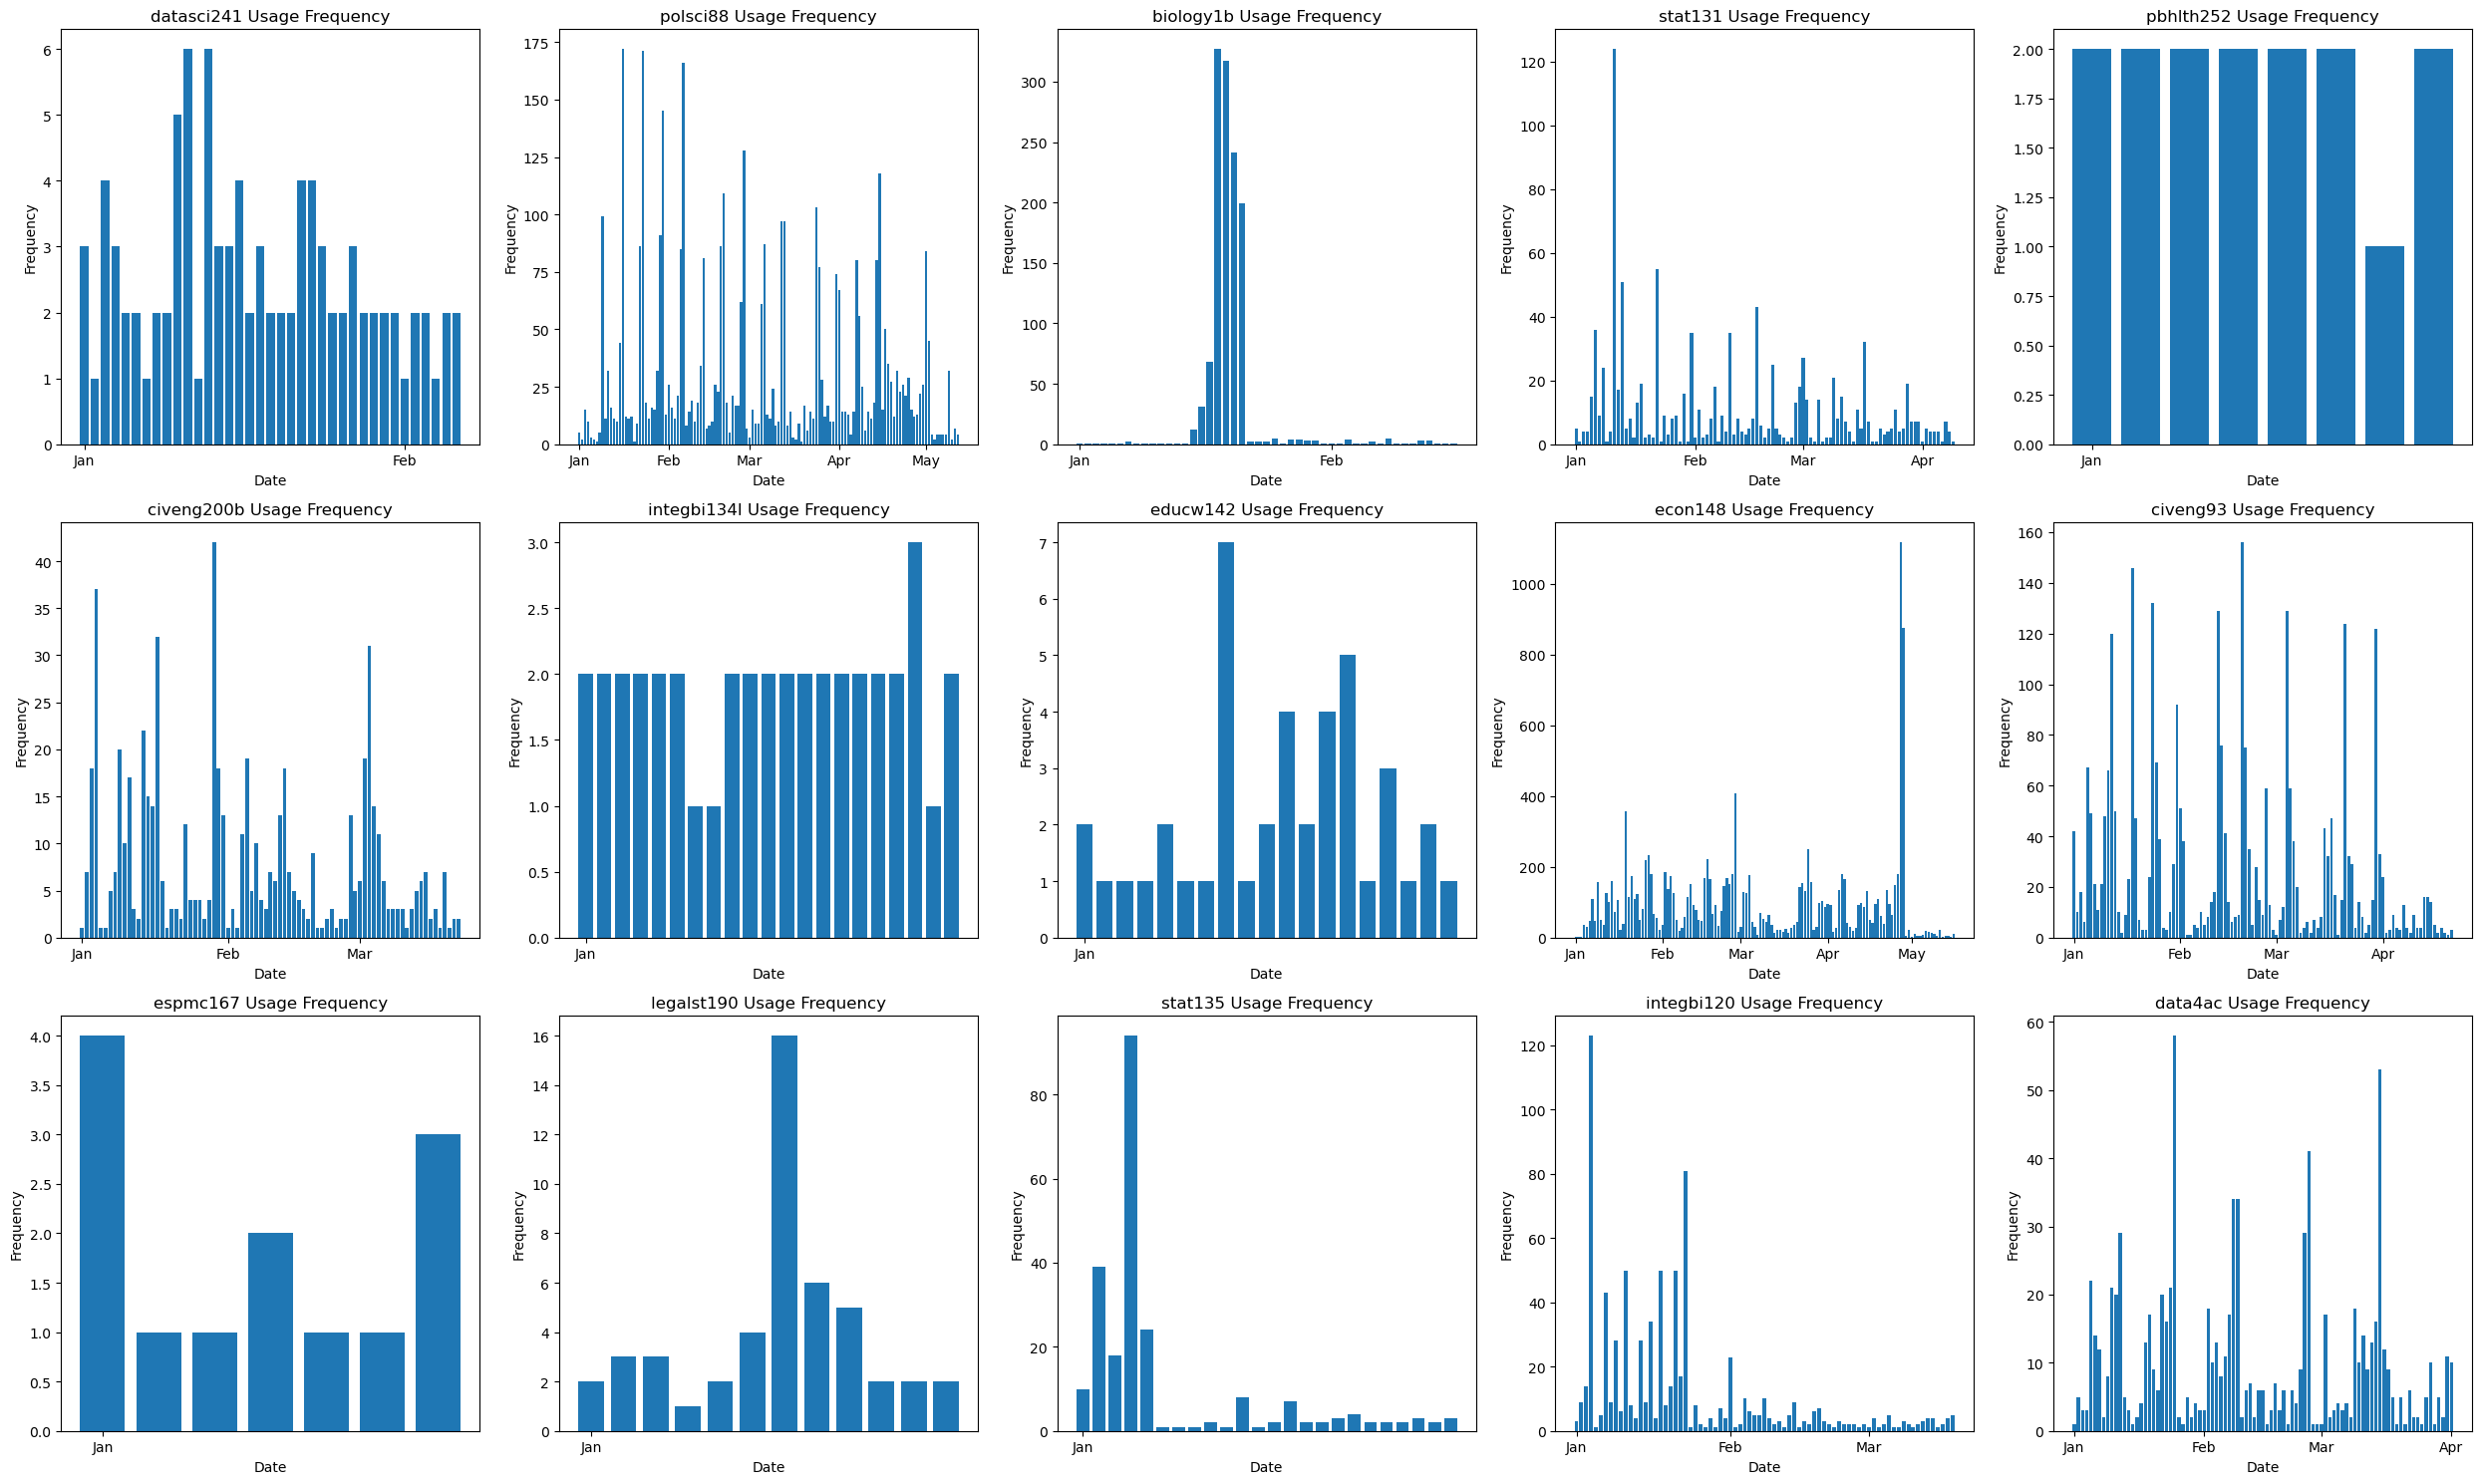

In [31]:
# look at plots 31-45
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+30]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+30]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

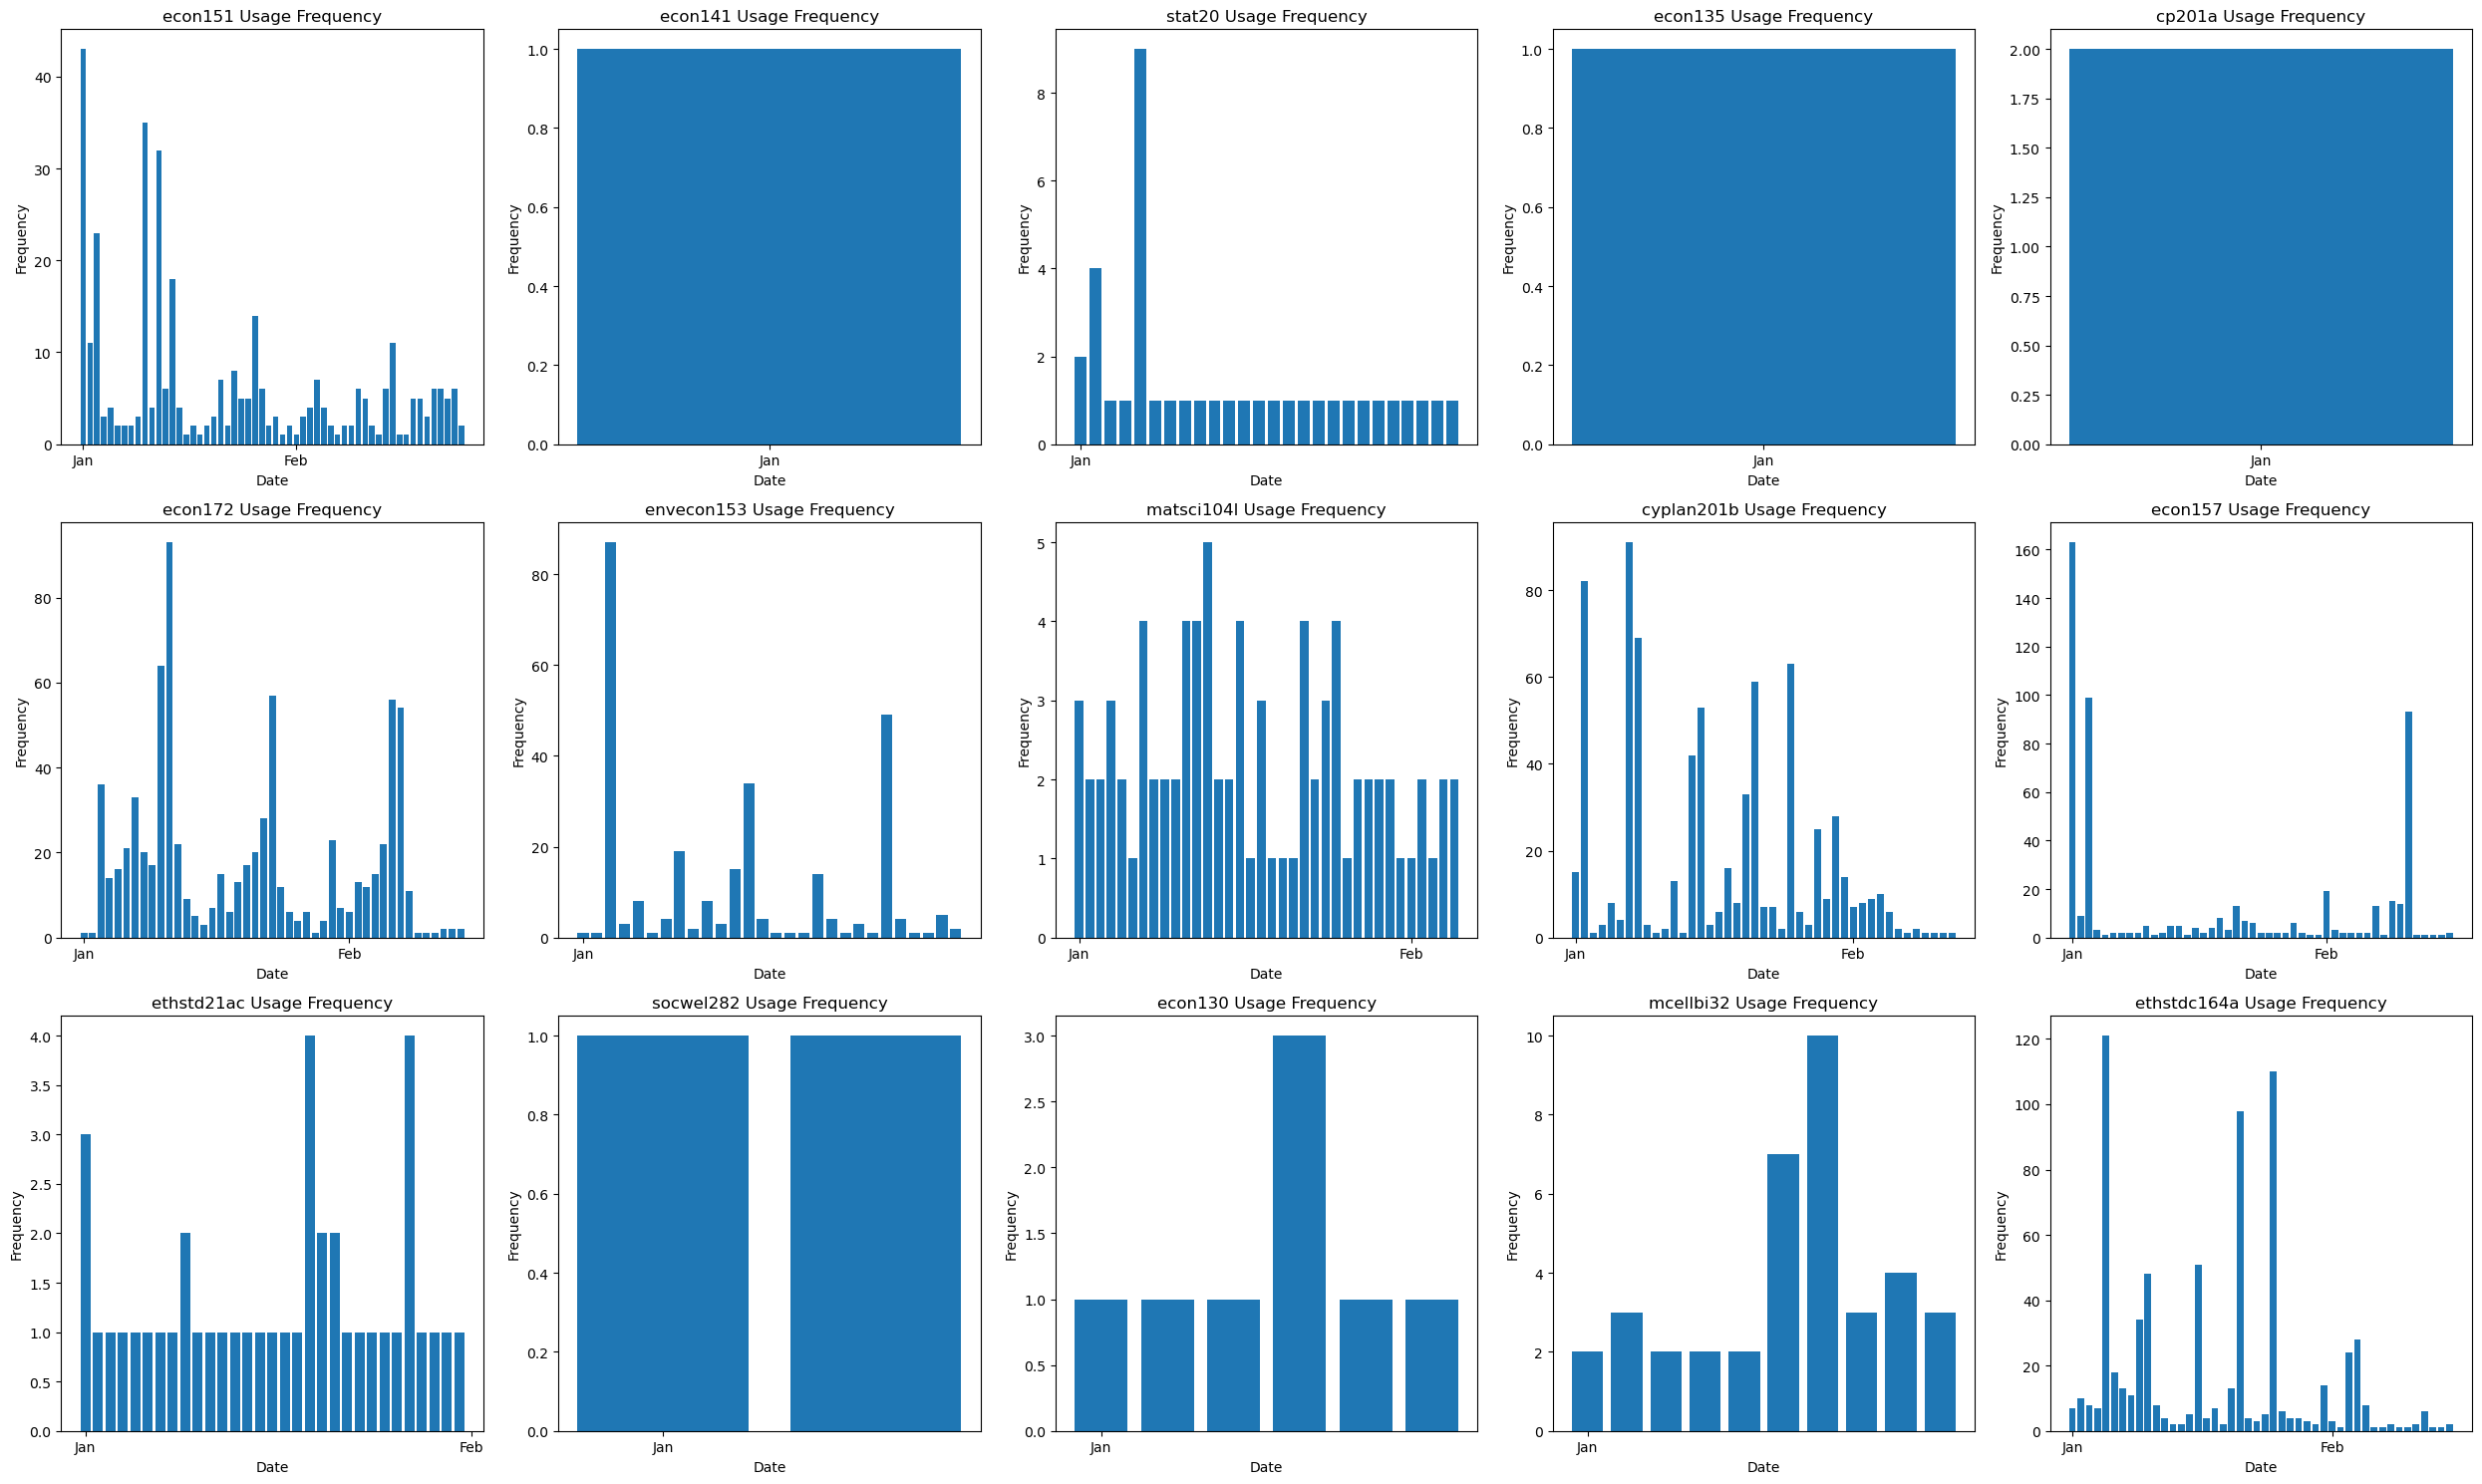

In [32]:
# look at plots 45-60
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+45]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+45]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

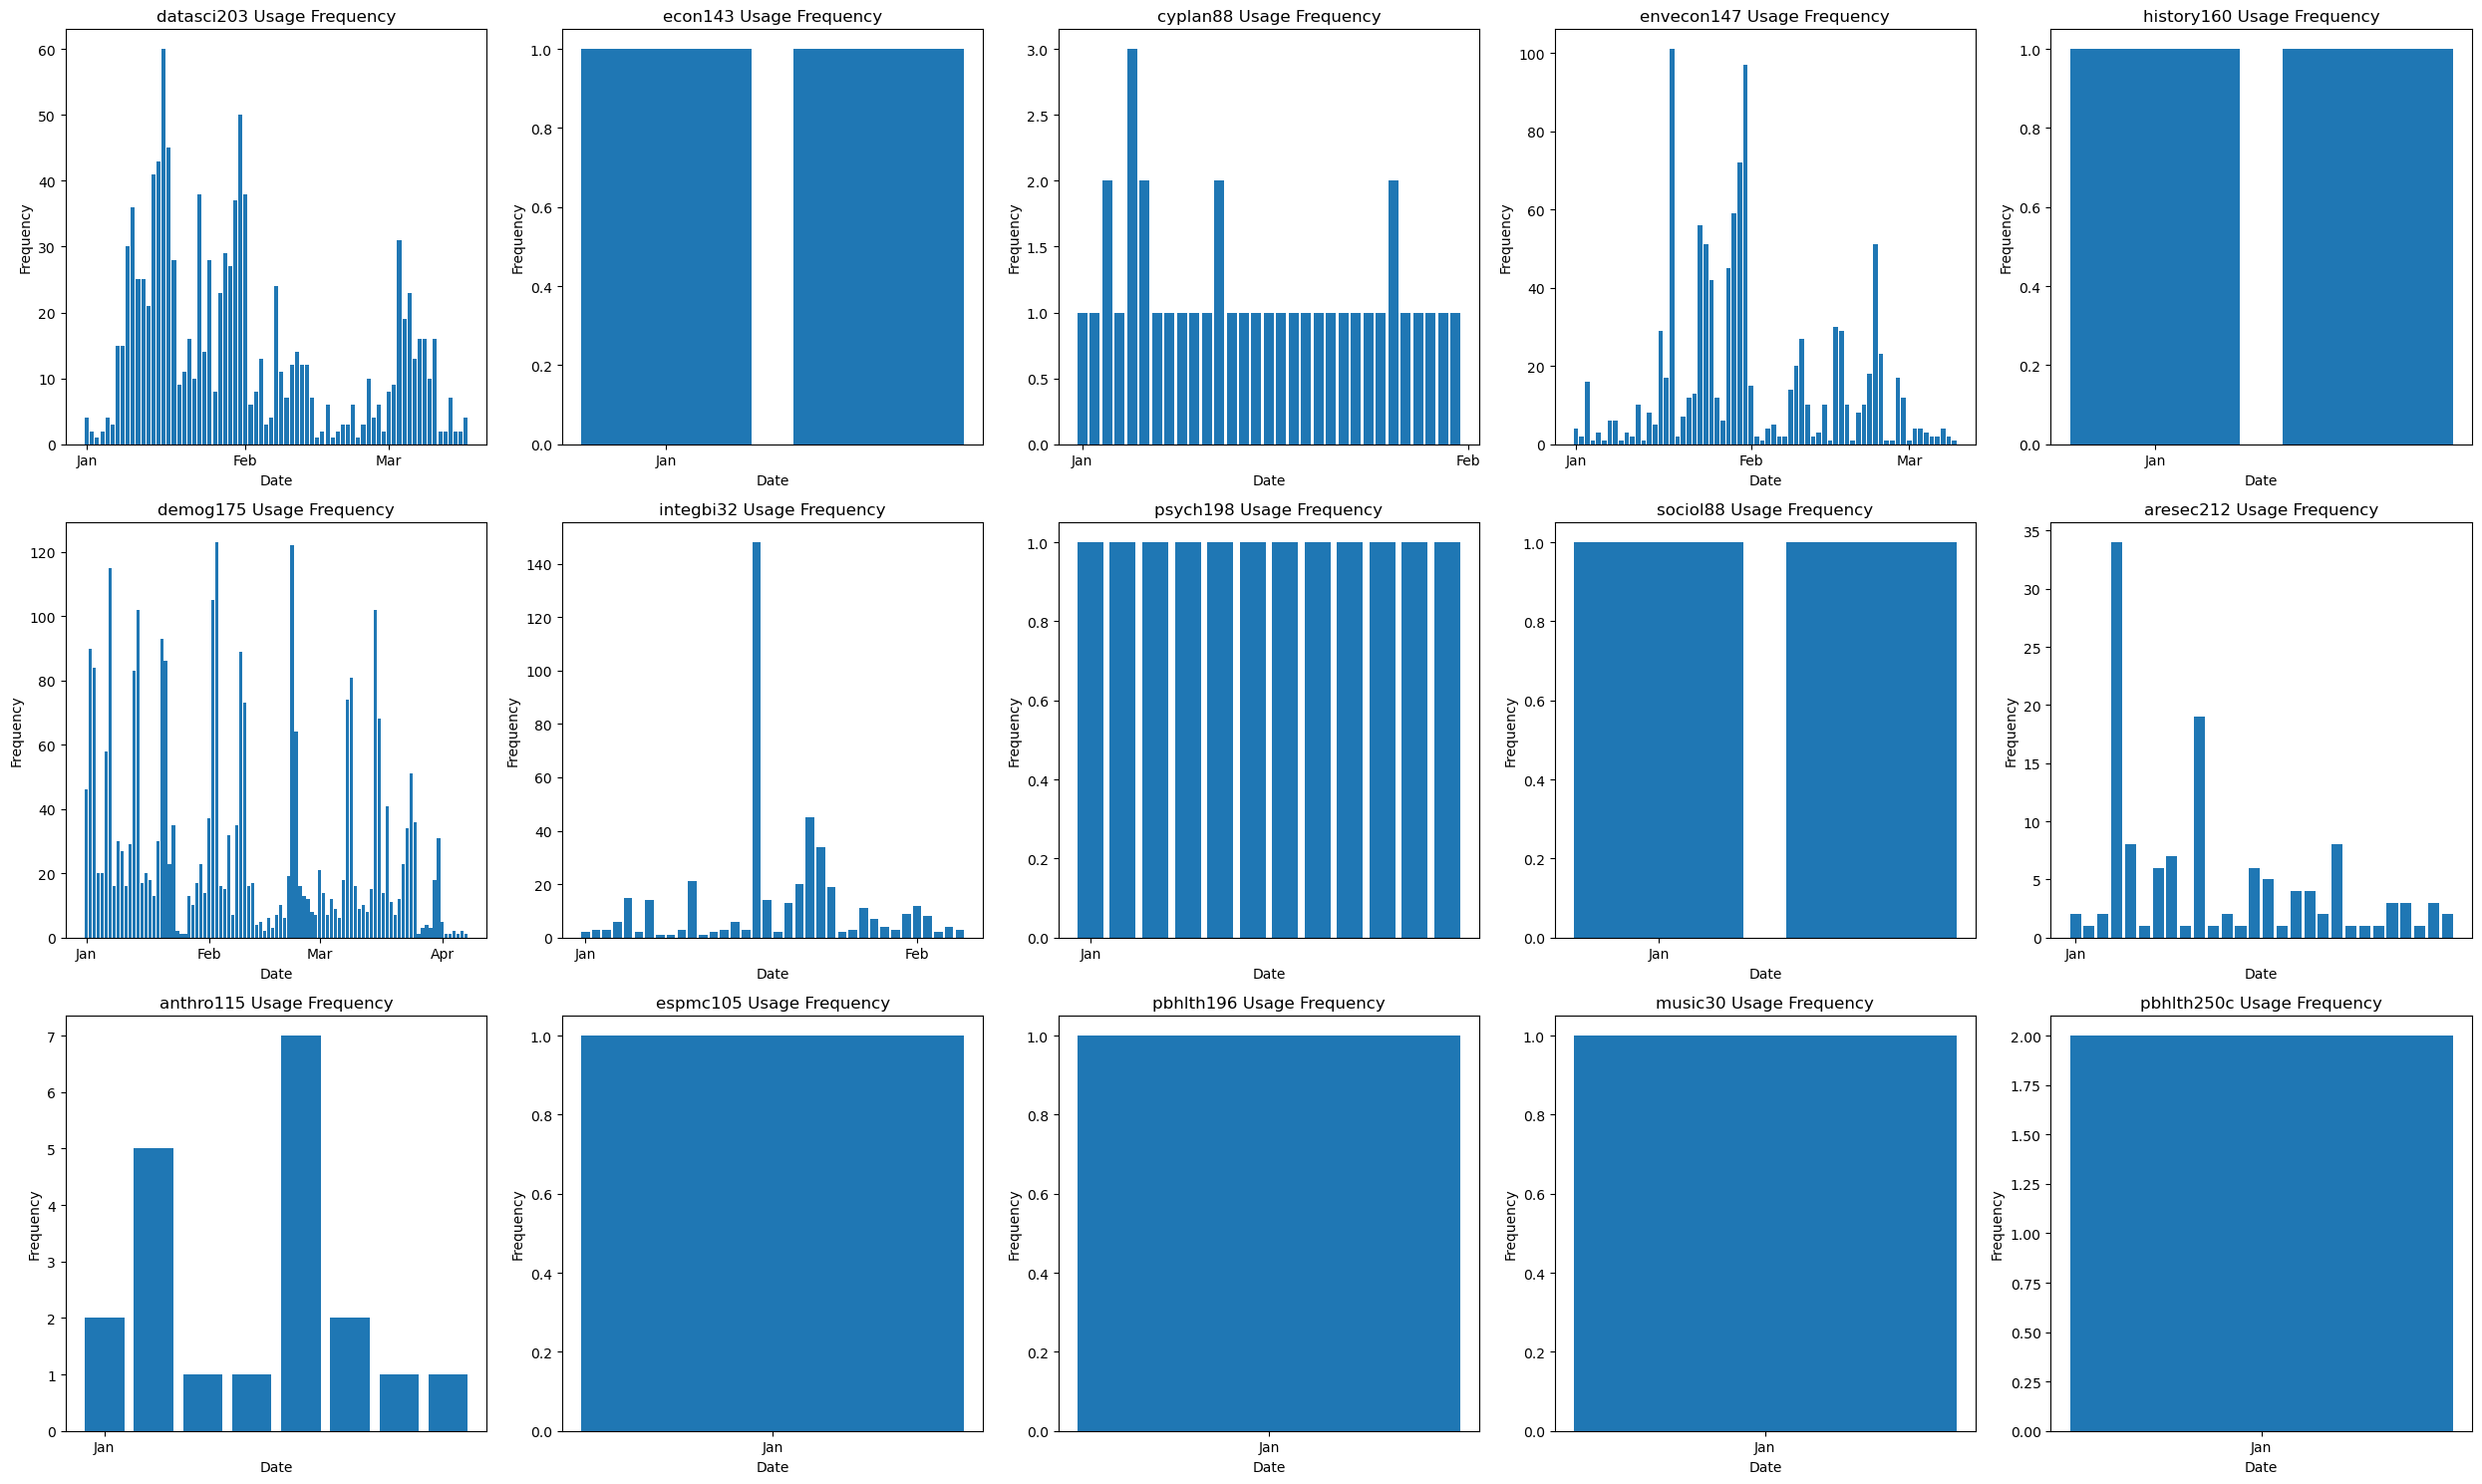

In [33]:
# look at plots 61-75
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+60]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+60]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

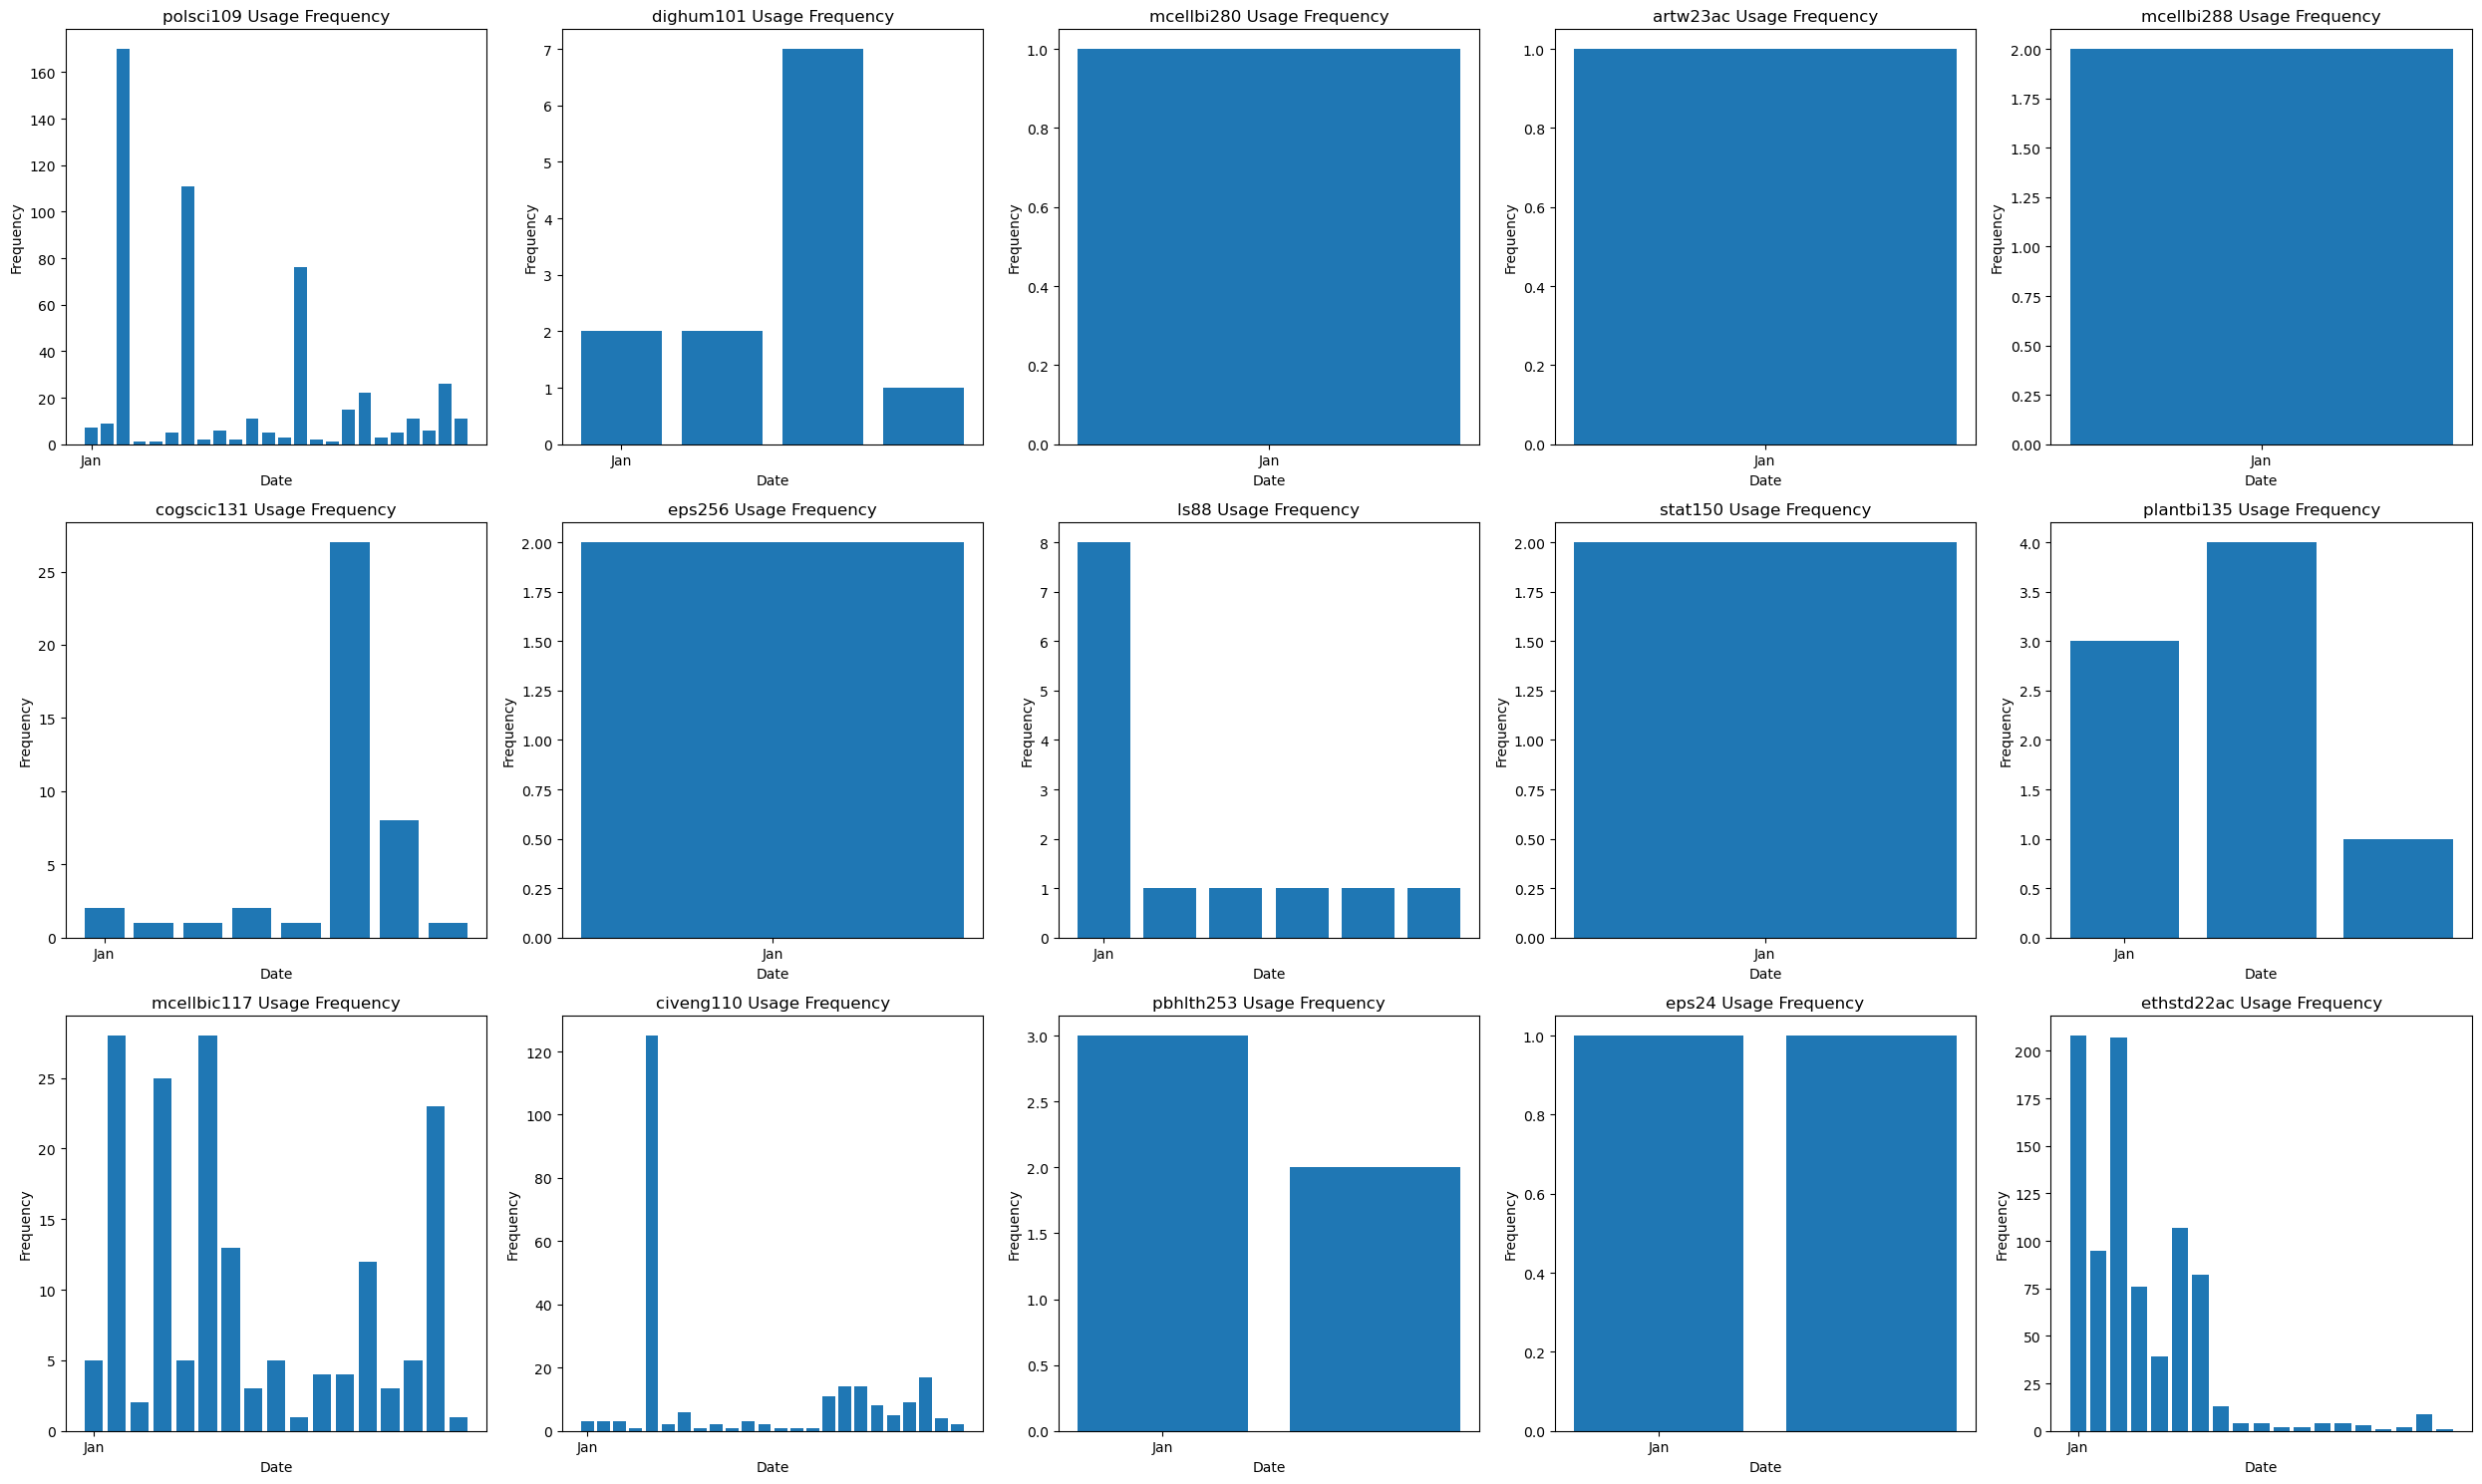

In [34]:
# look at plots 76-90
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+75]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+75]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

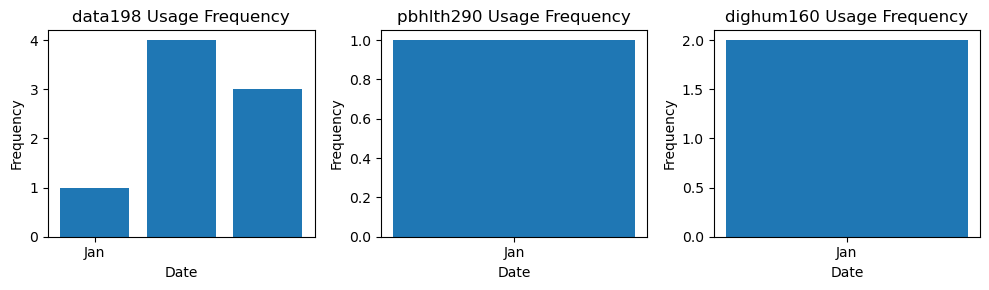

In [35]:
# look at plots 91-93
total_plots = 3
total_columns = 3
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(10, 3))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+90]].reset_index()
    courses_date = course.groupby(by = 'timestamp_date').timestamp_date.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_date.index, courses_date)

    ax.set_title(f'{unique_courses[k+90]} Usage Frequency')
    ax.set_xlabel('Date')
    ax.set_ylabel('Frequency')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# axes[2,1].set_axis_off()
plt.tight_layout()

##### Making Graphs of Time of Usage Per Course

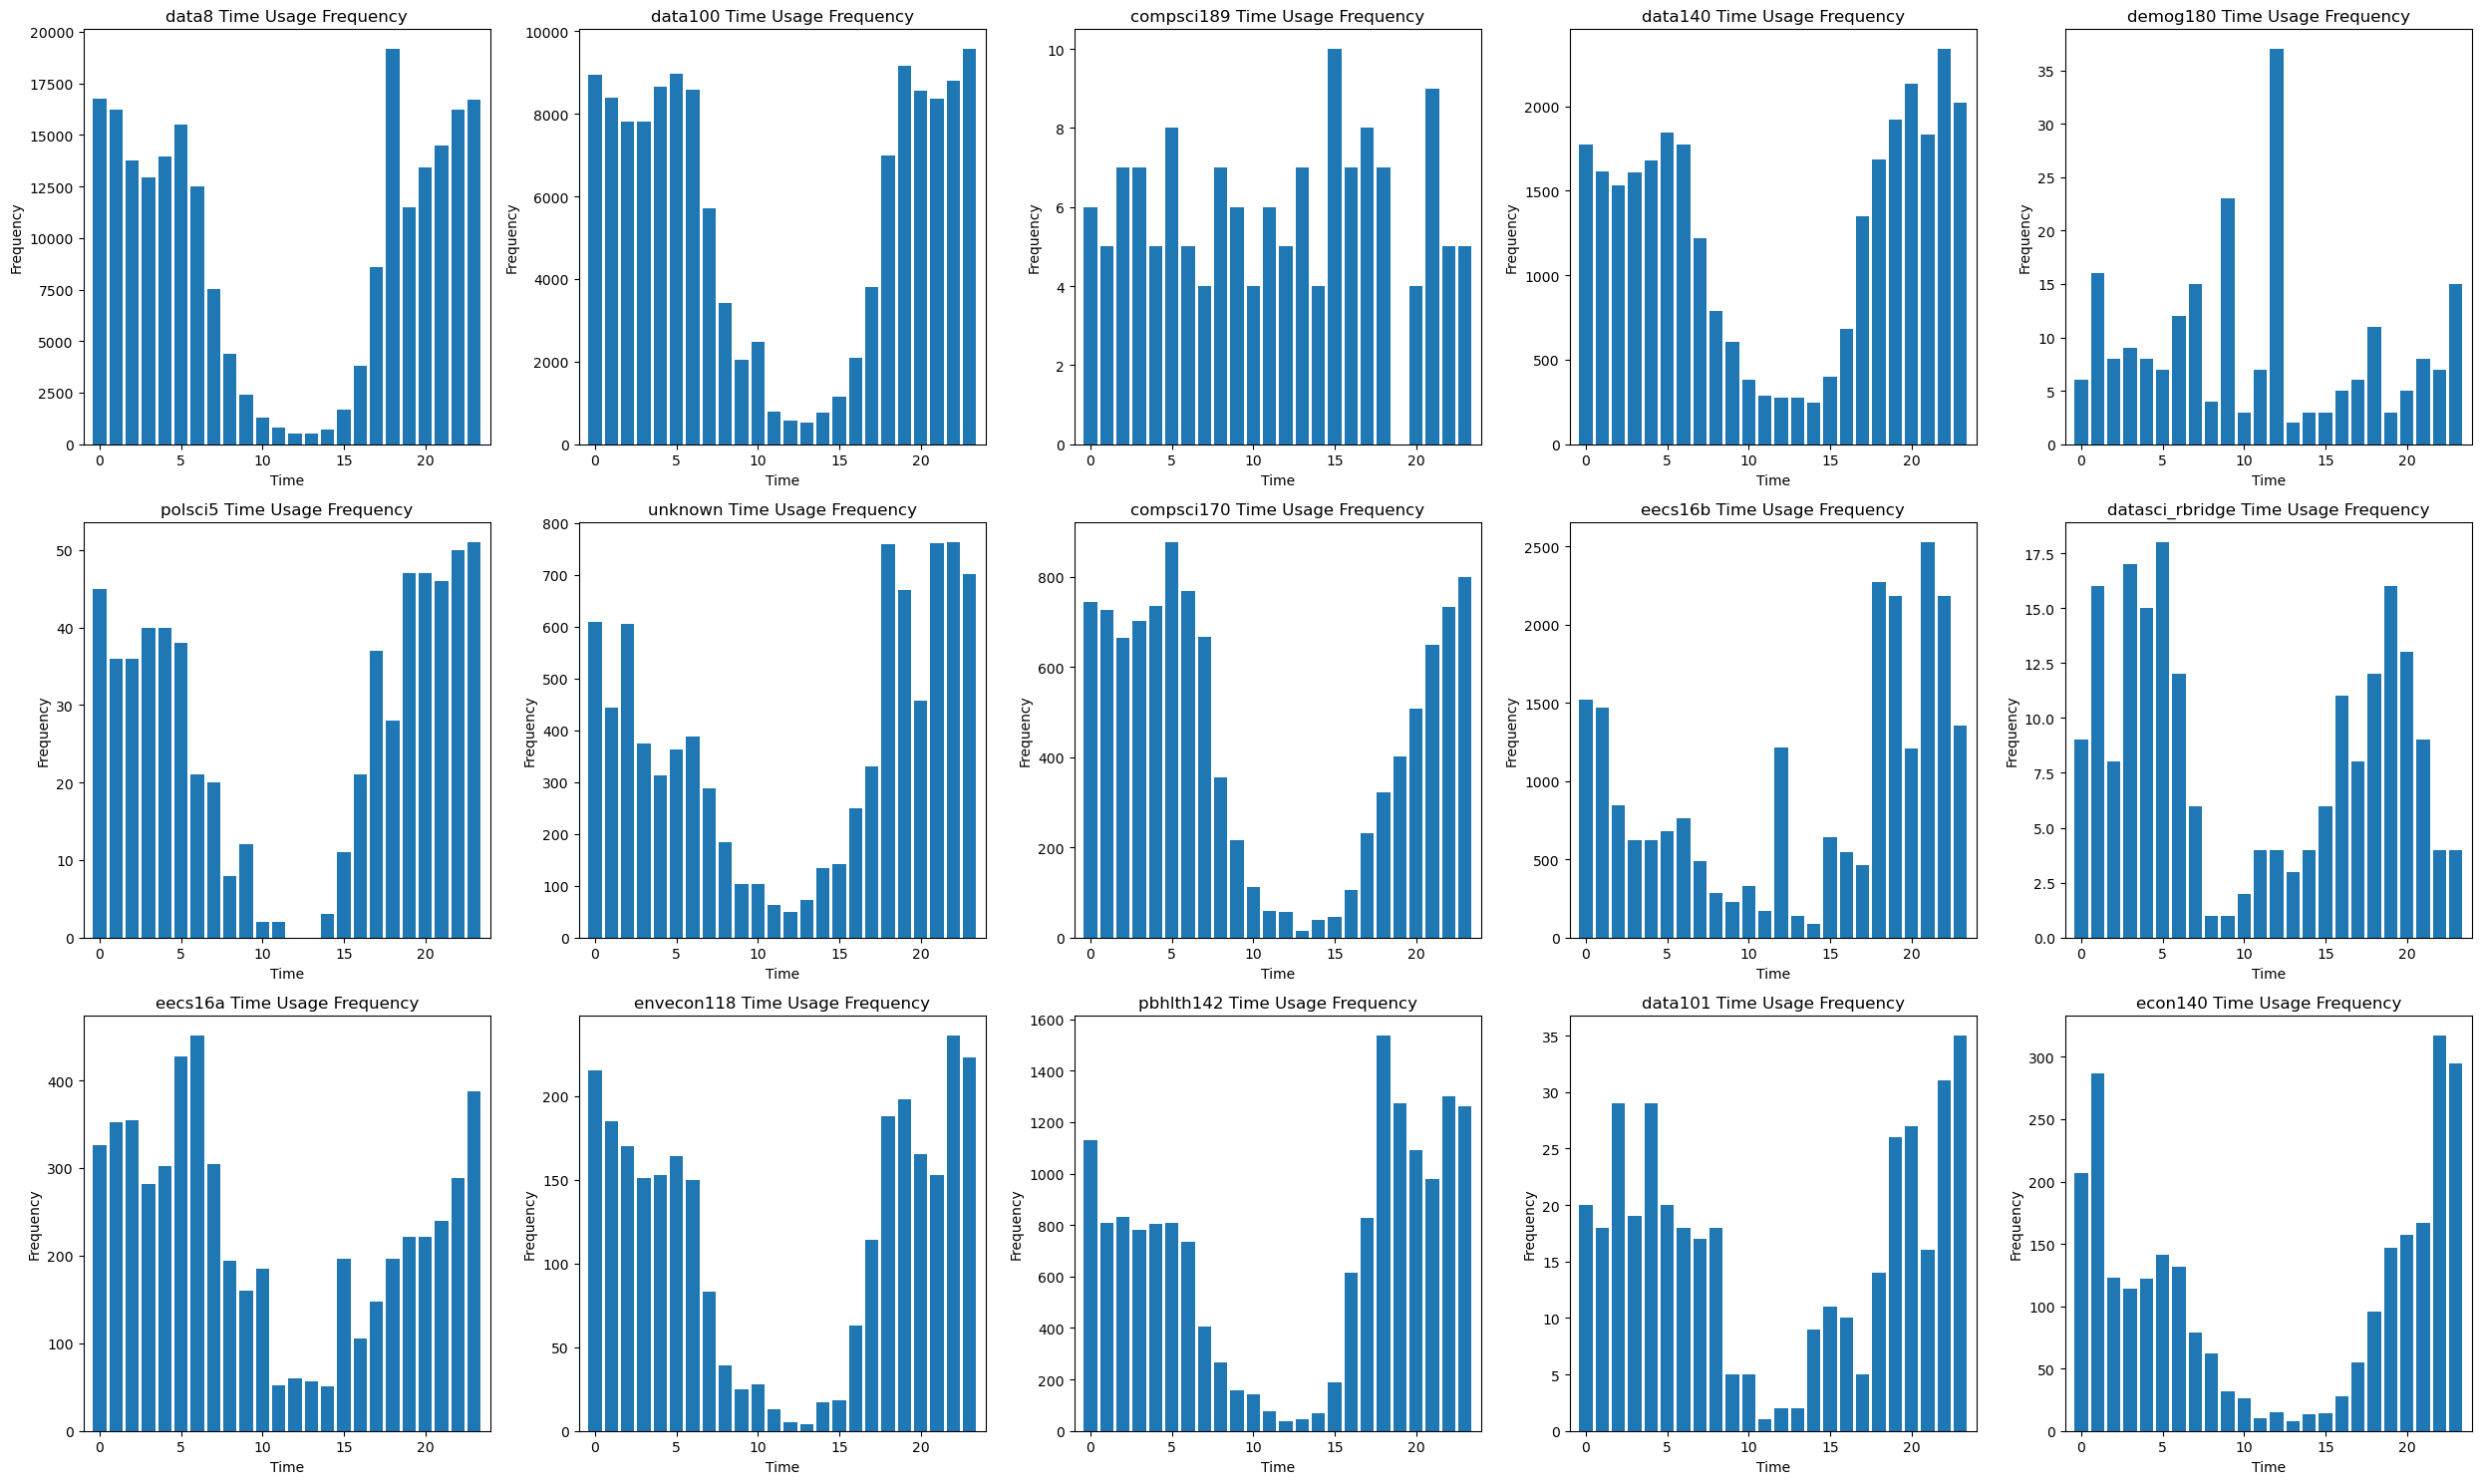

In [36]:
# look at usage time by courses 1-15
unique_courses = nbgitpuller_textPayload_df_pull_normal.course.unique()


# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15), sharex = False)
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

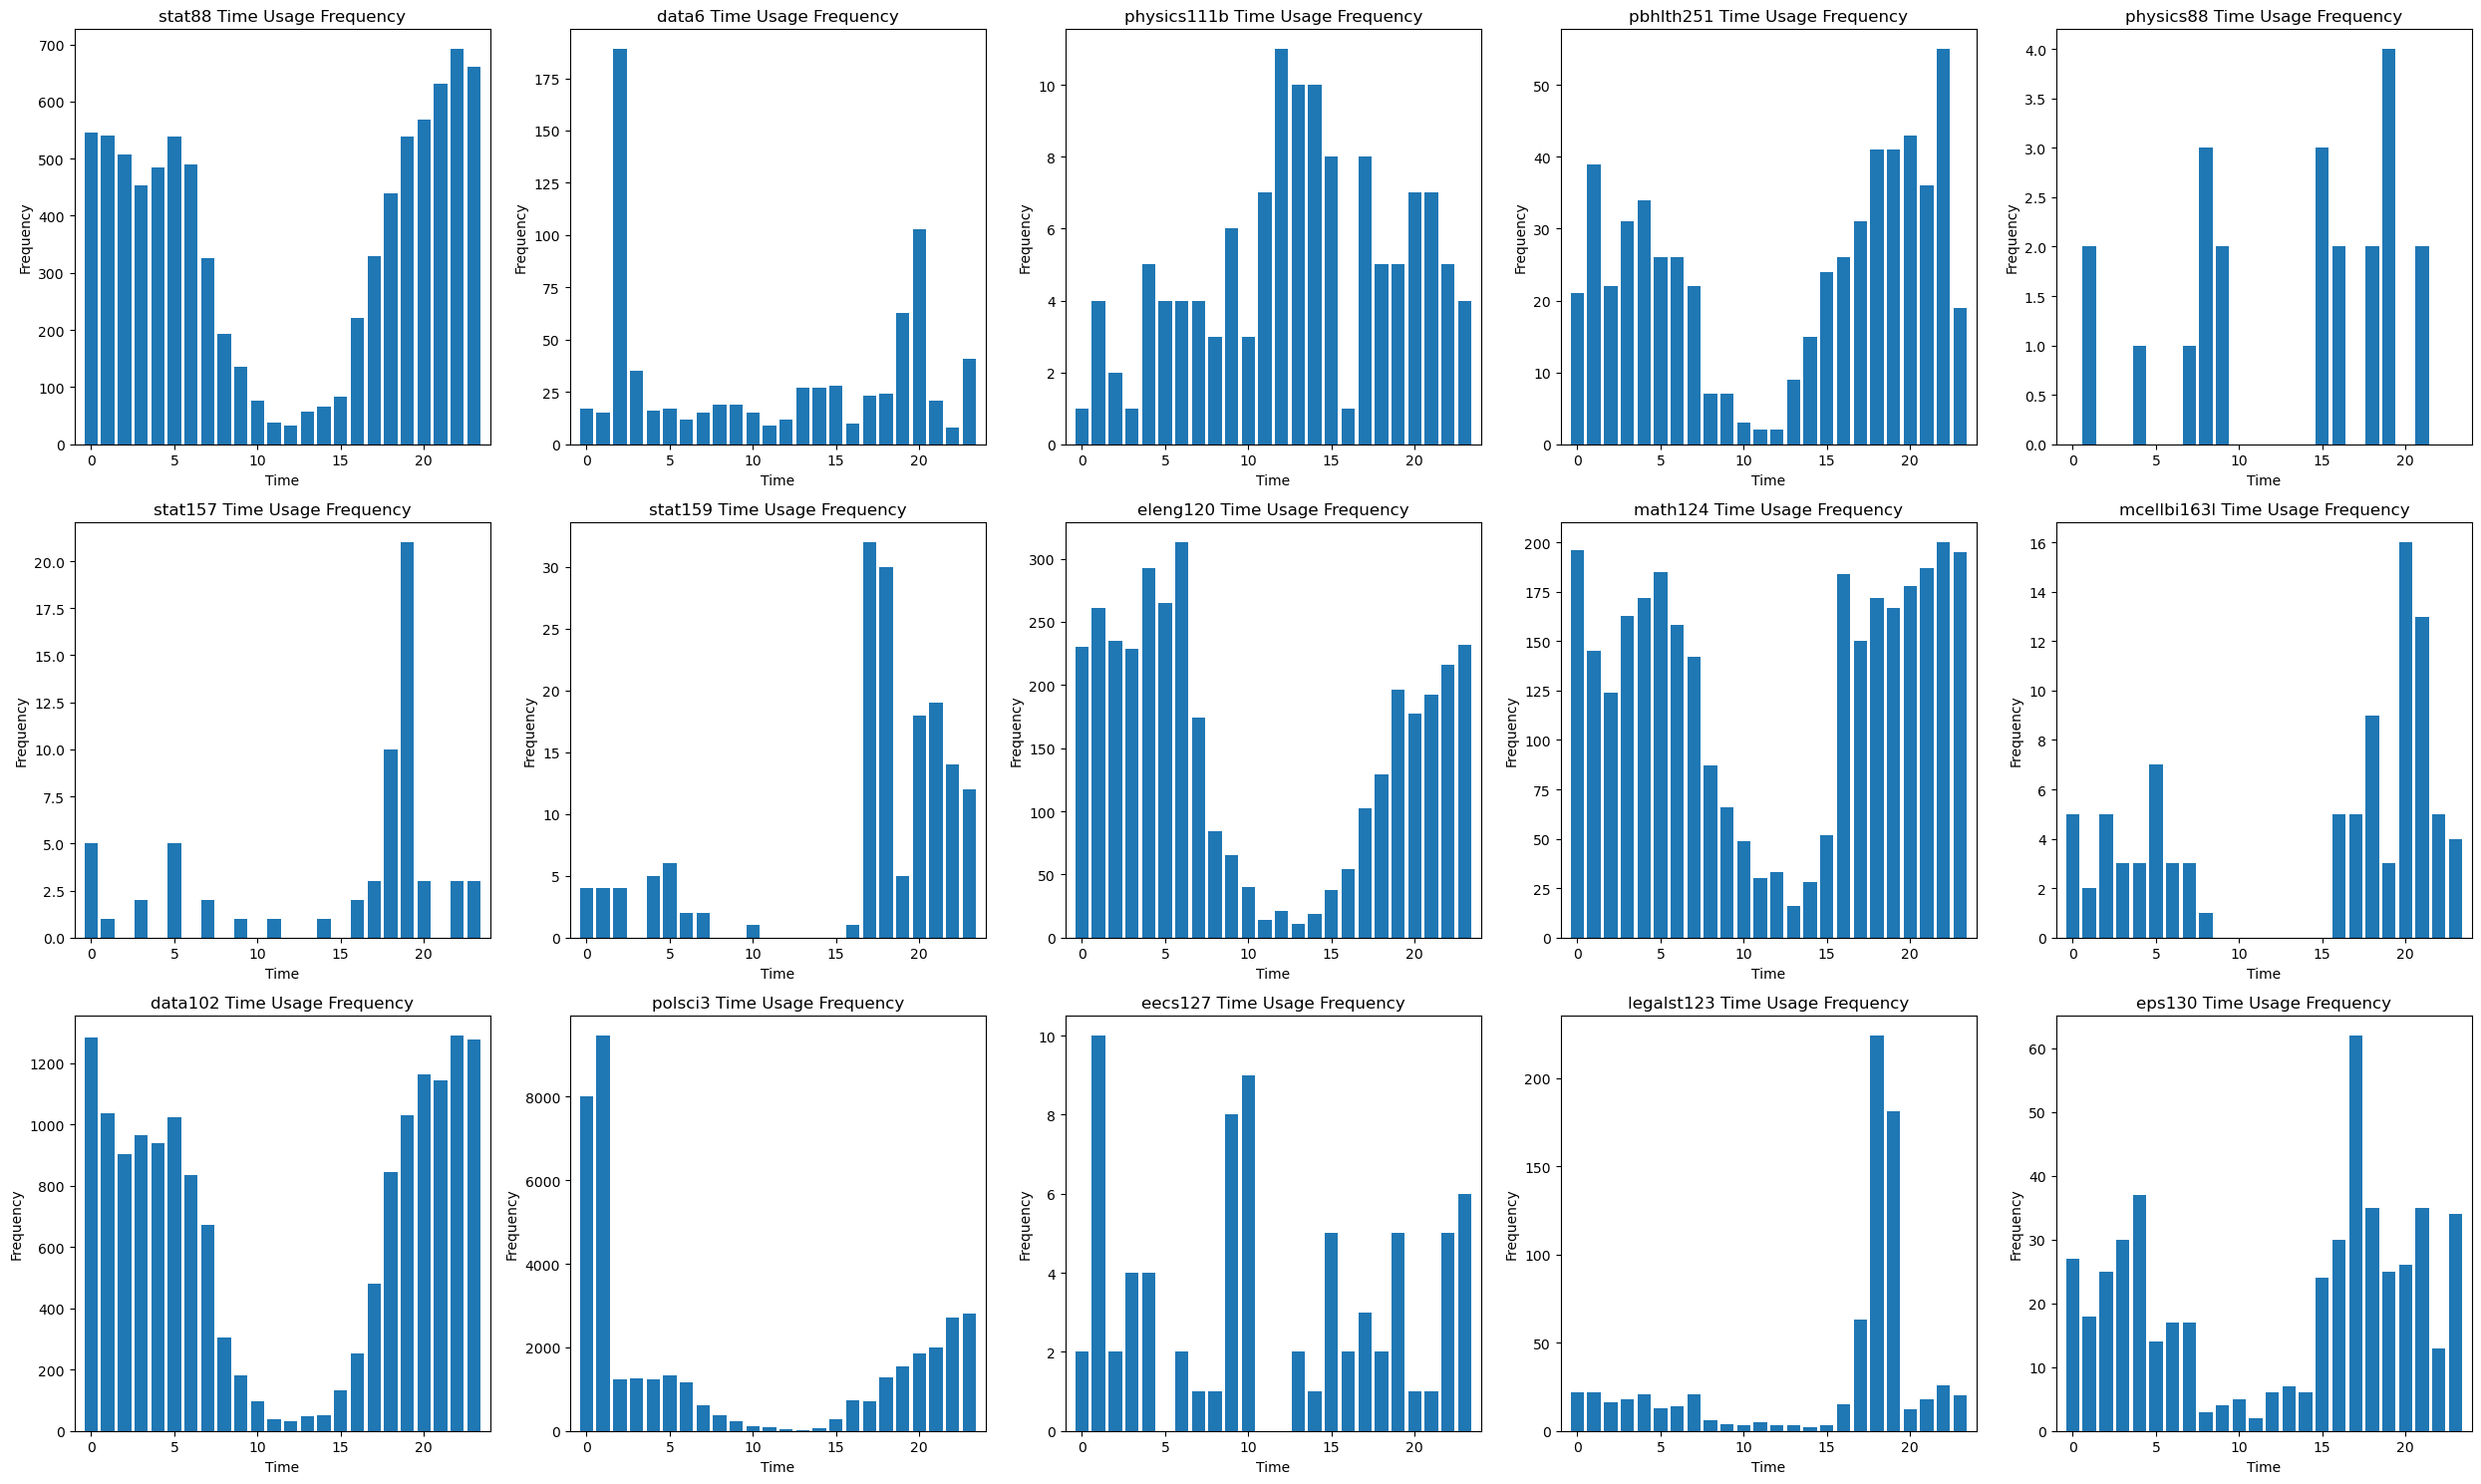

In [37]:
# look at usage time by course 16-30
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+15]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+15]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

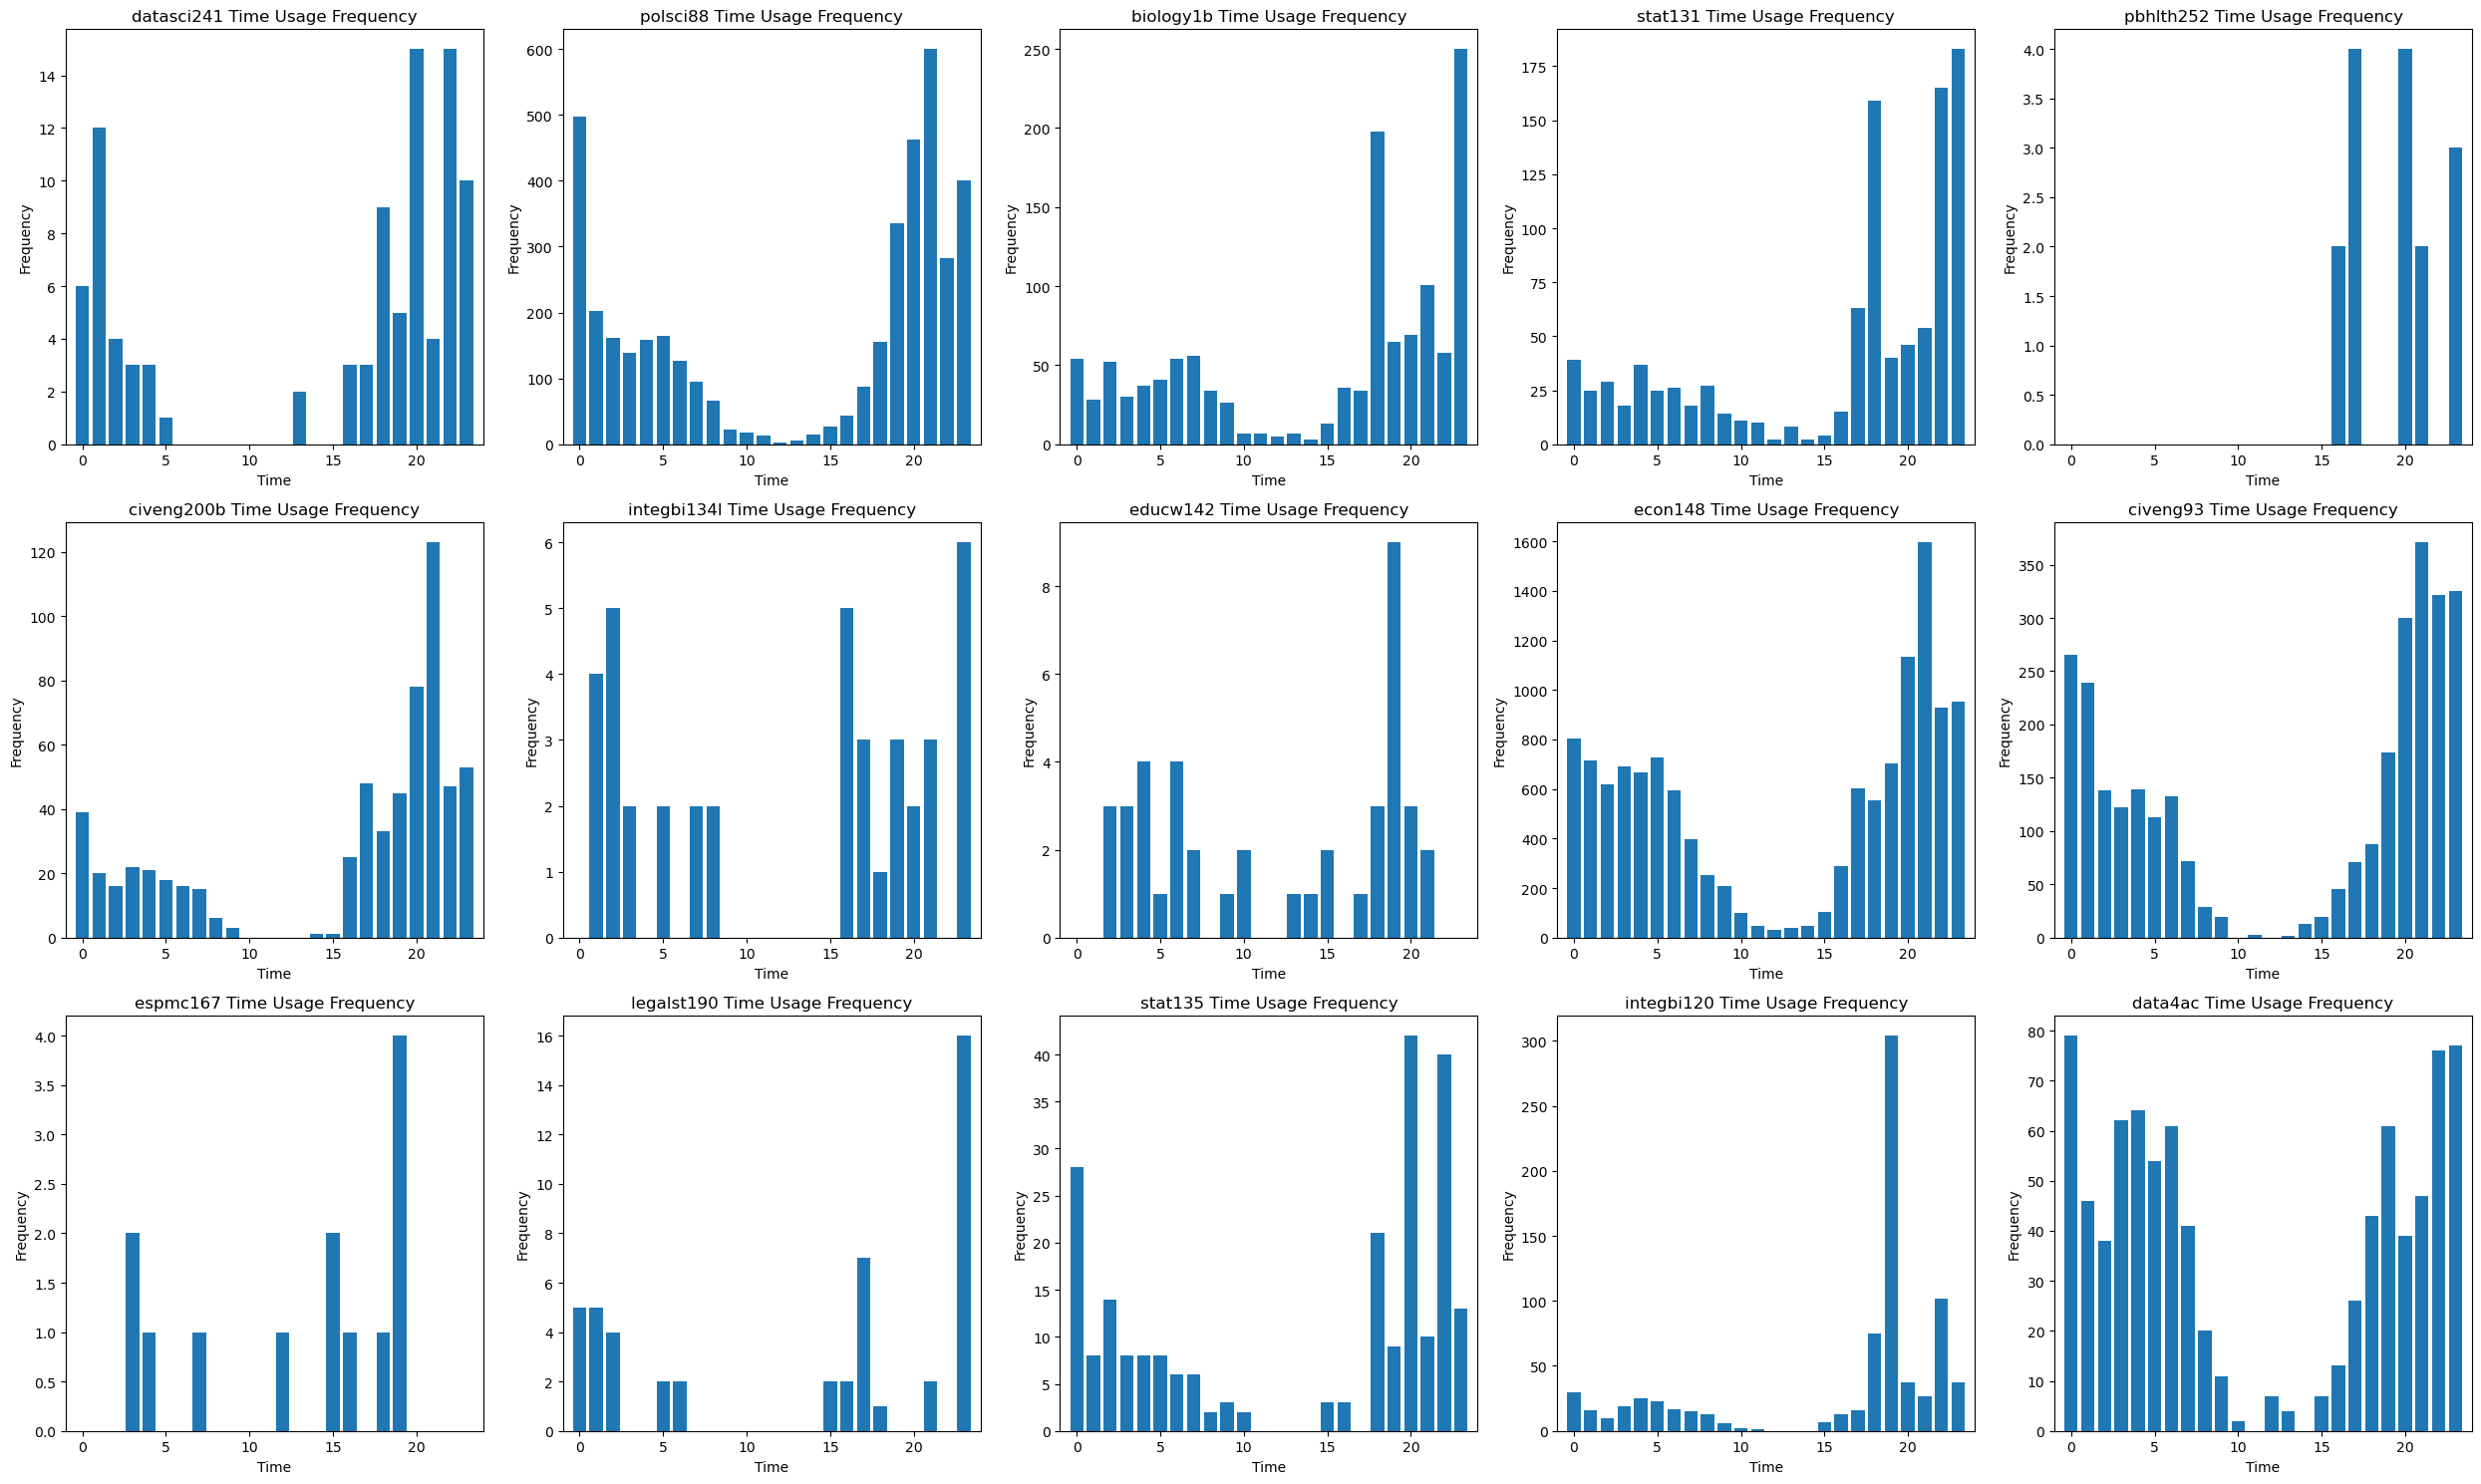

In [38]:
# look at usage time by course 31 - 45
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+30]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+30]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

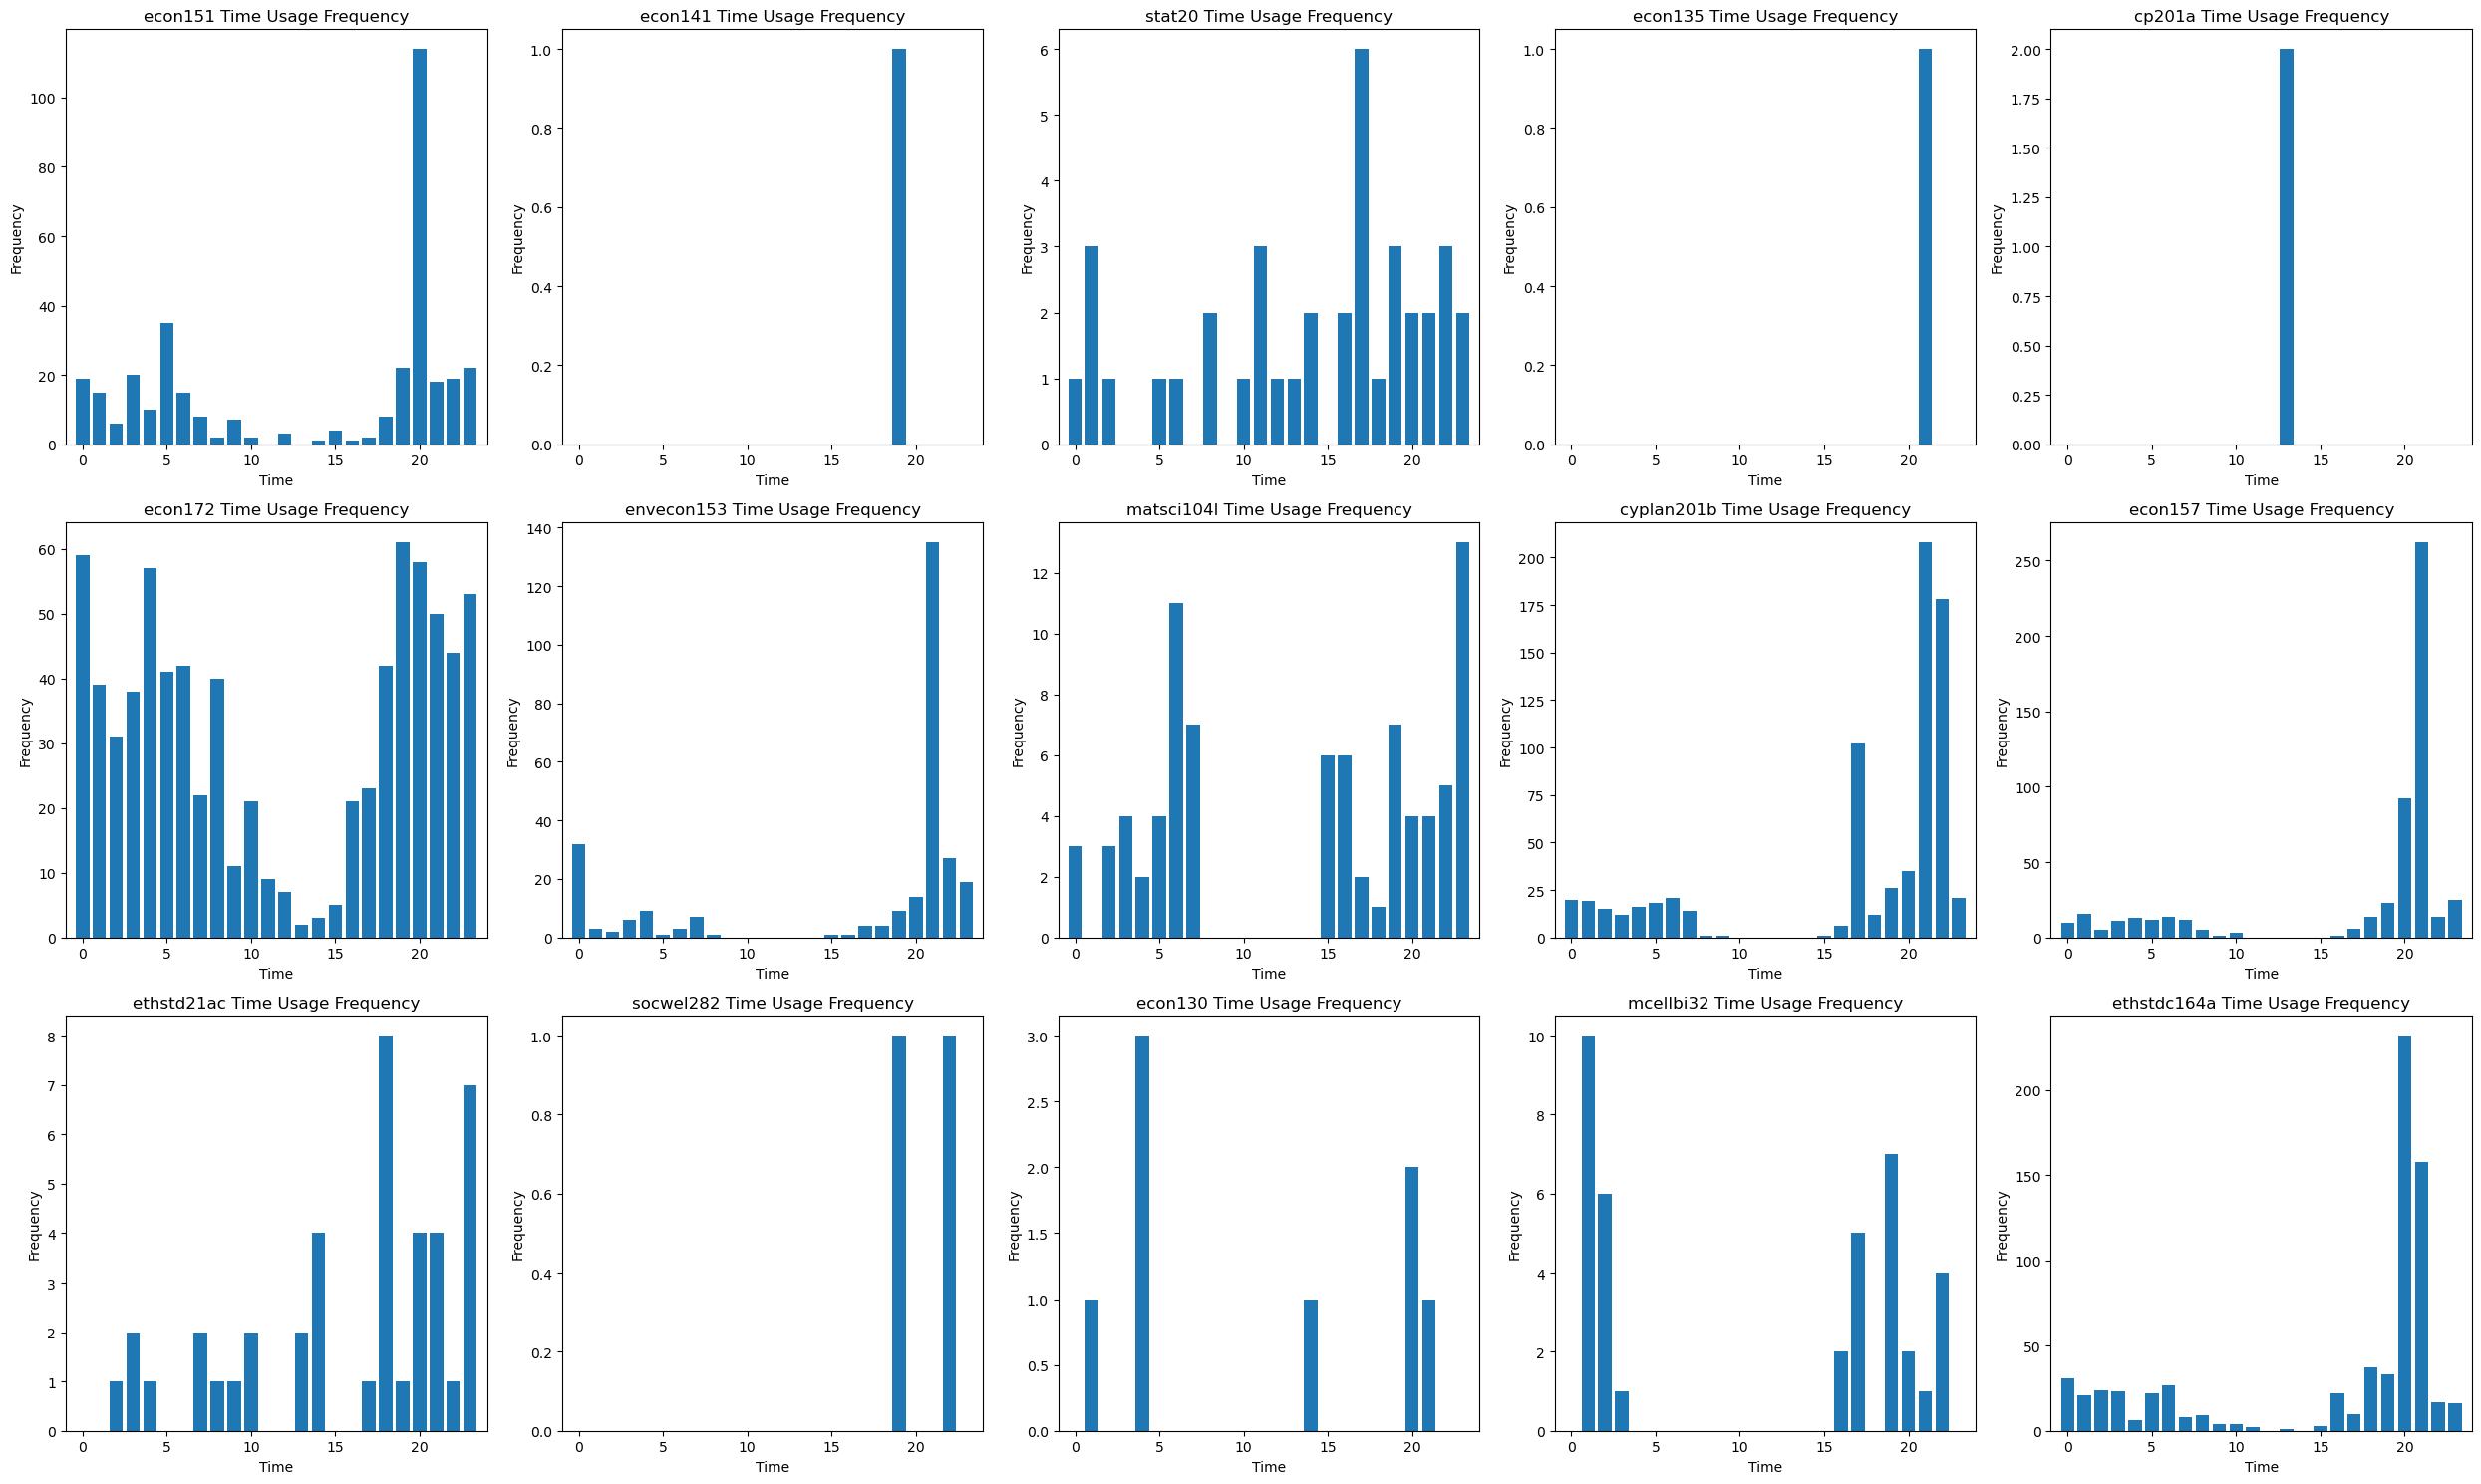

In [39]:
# look at usage time by course 46 - 60
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+45]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+45]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

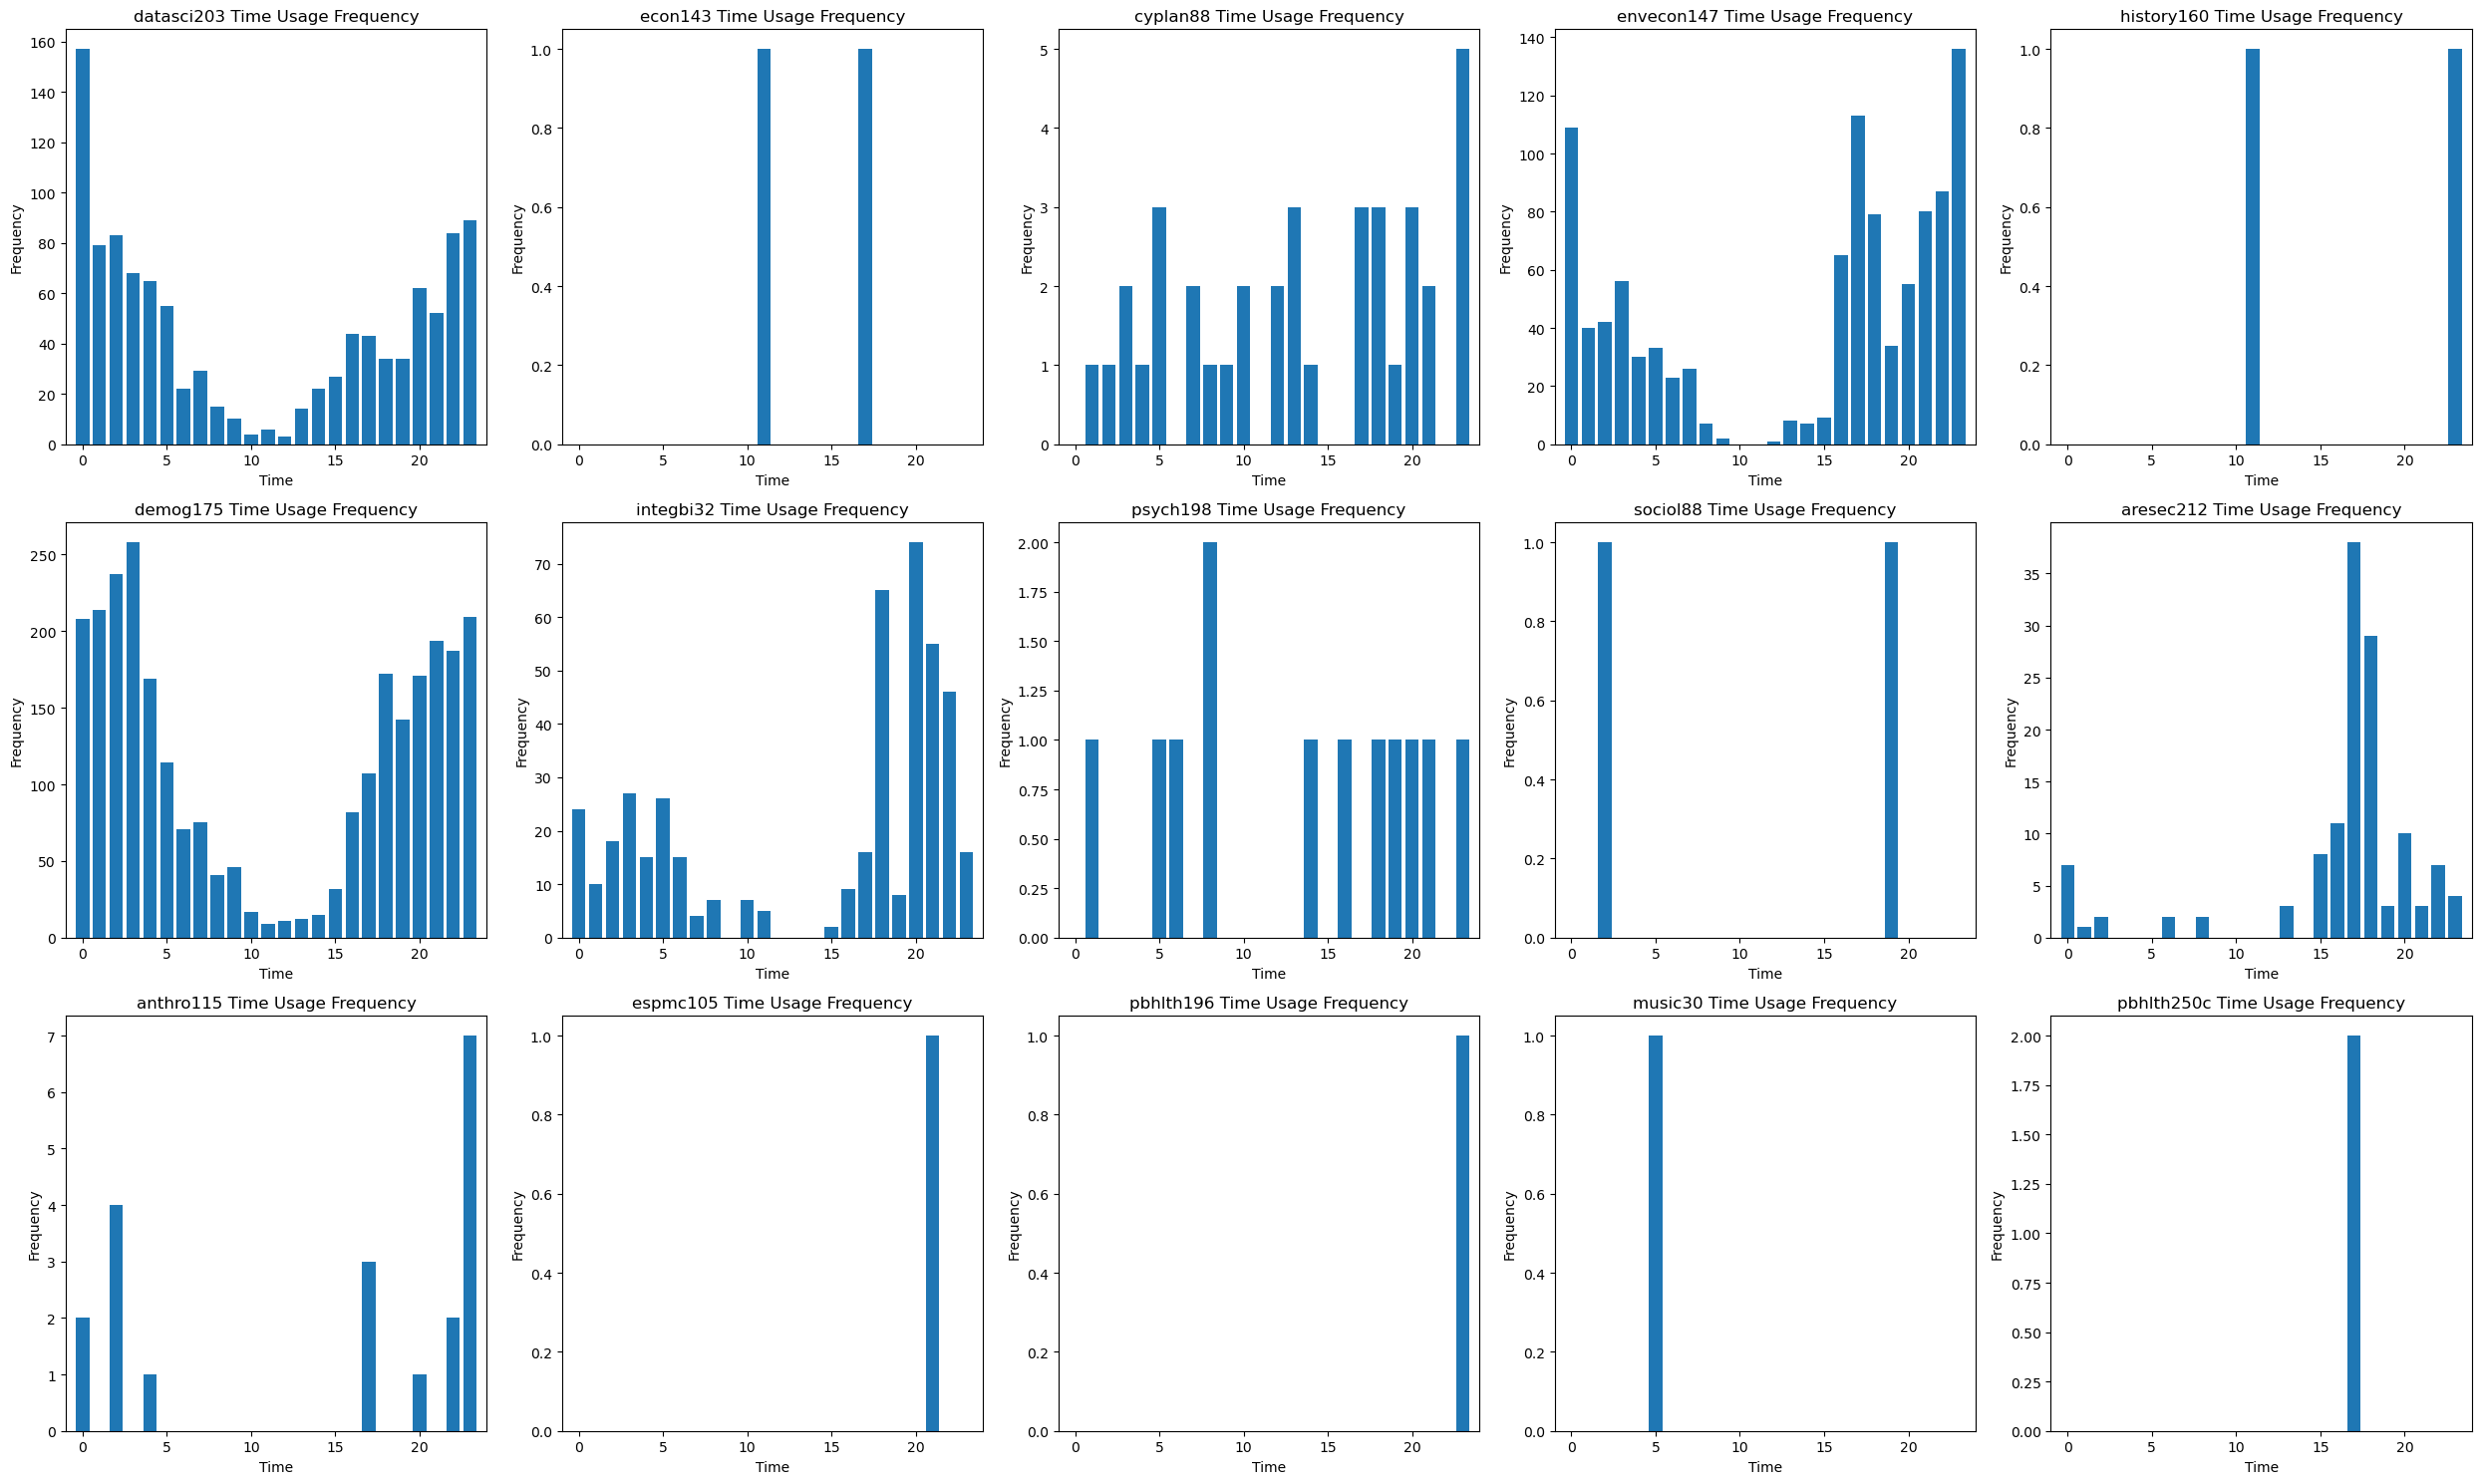

In [40]:
# look at usage time by course 61 - 75
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+60]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+60]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

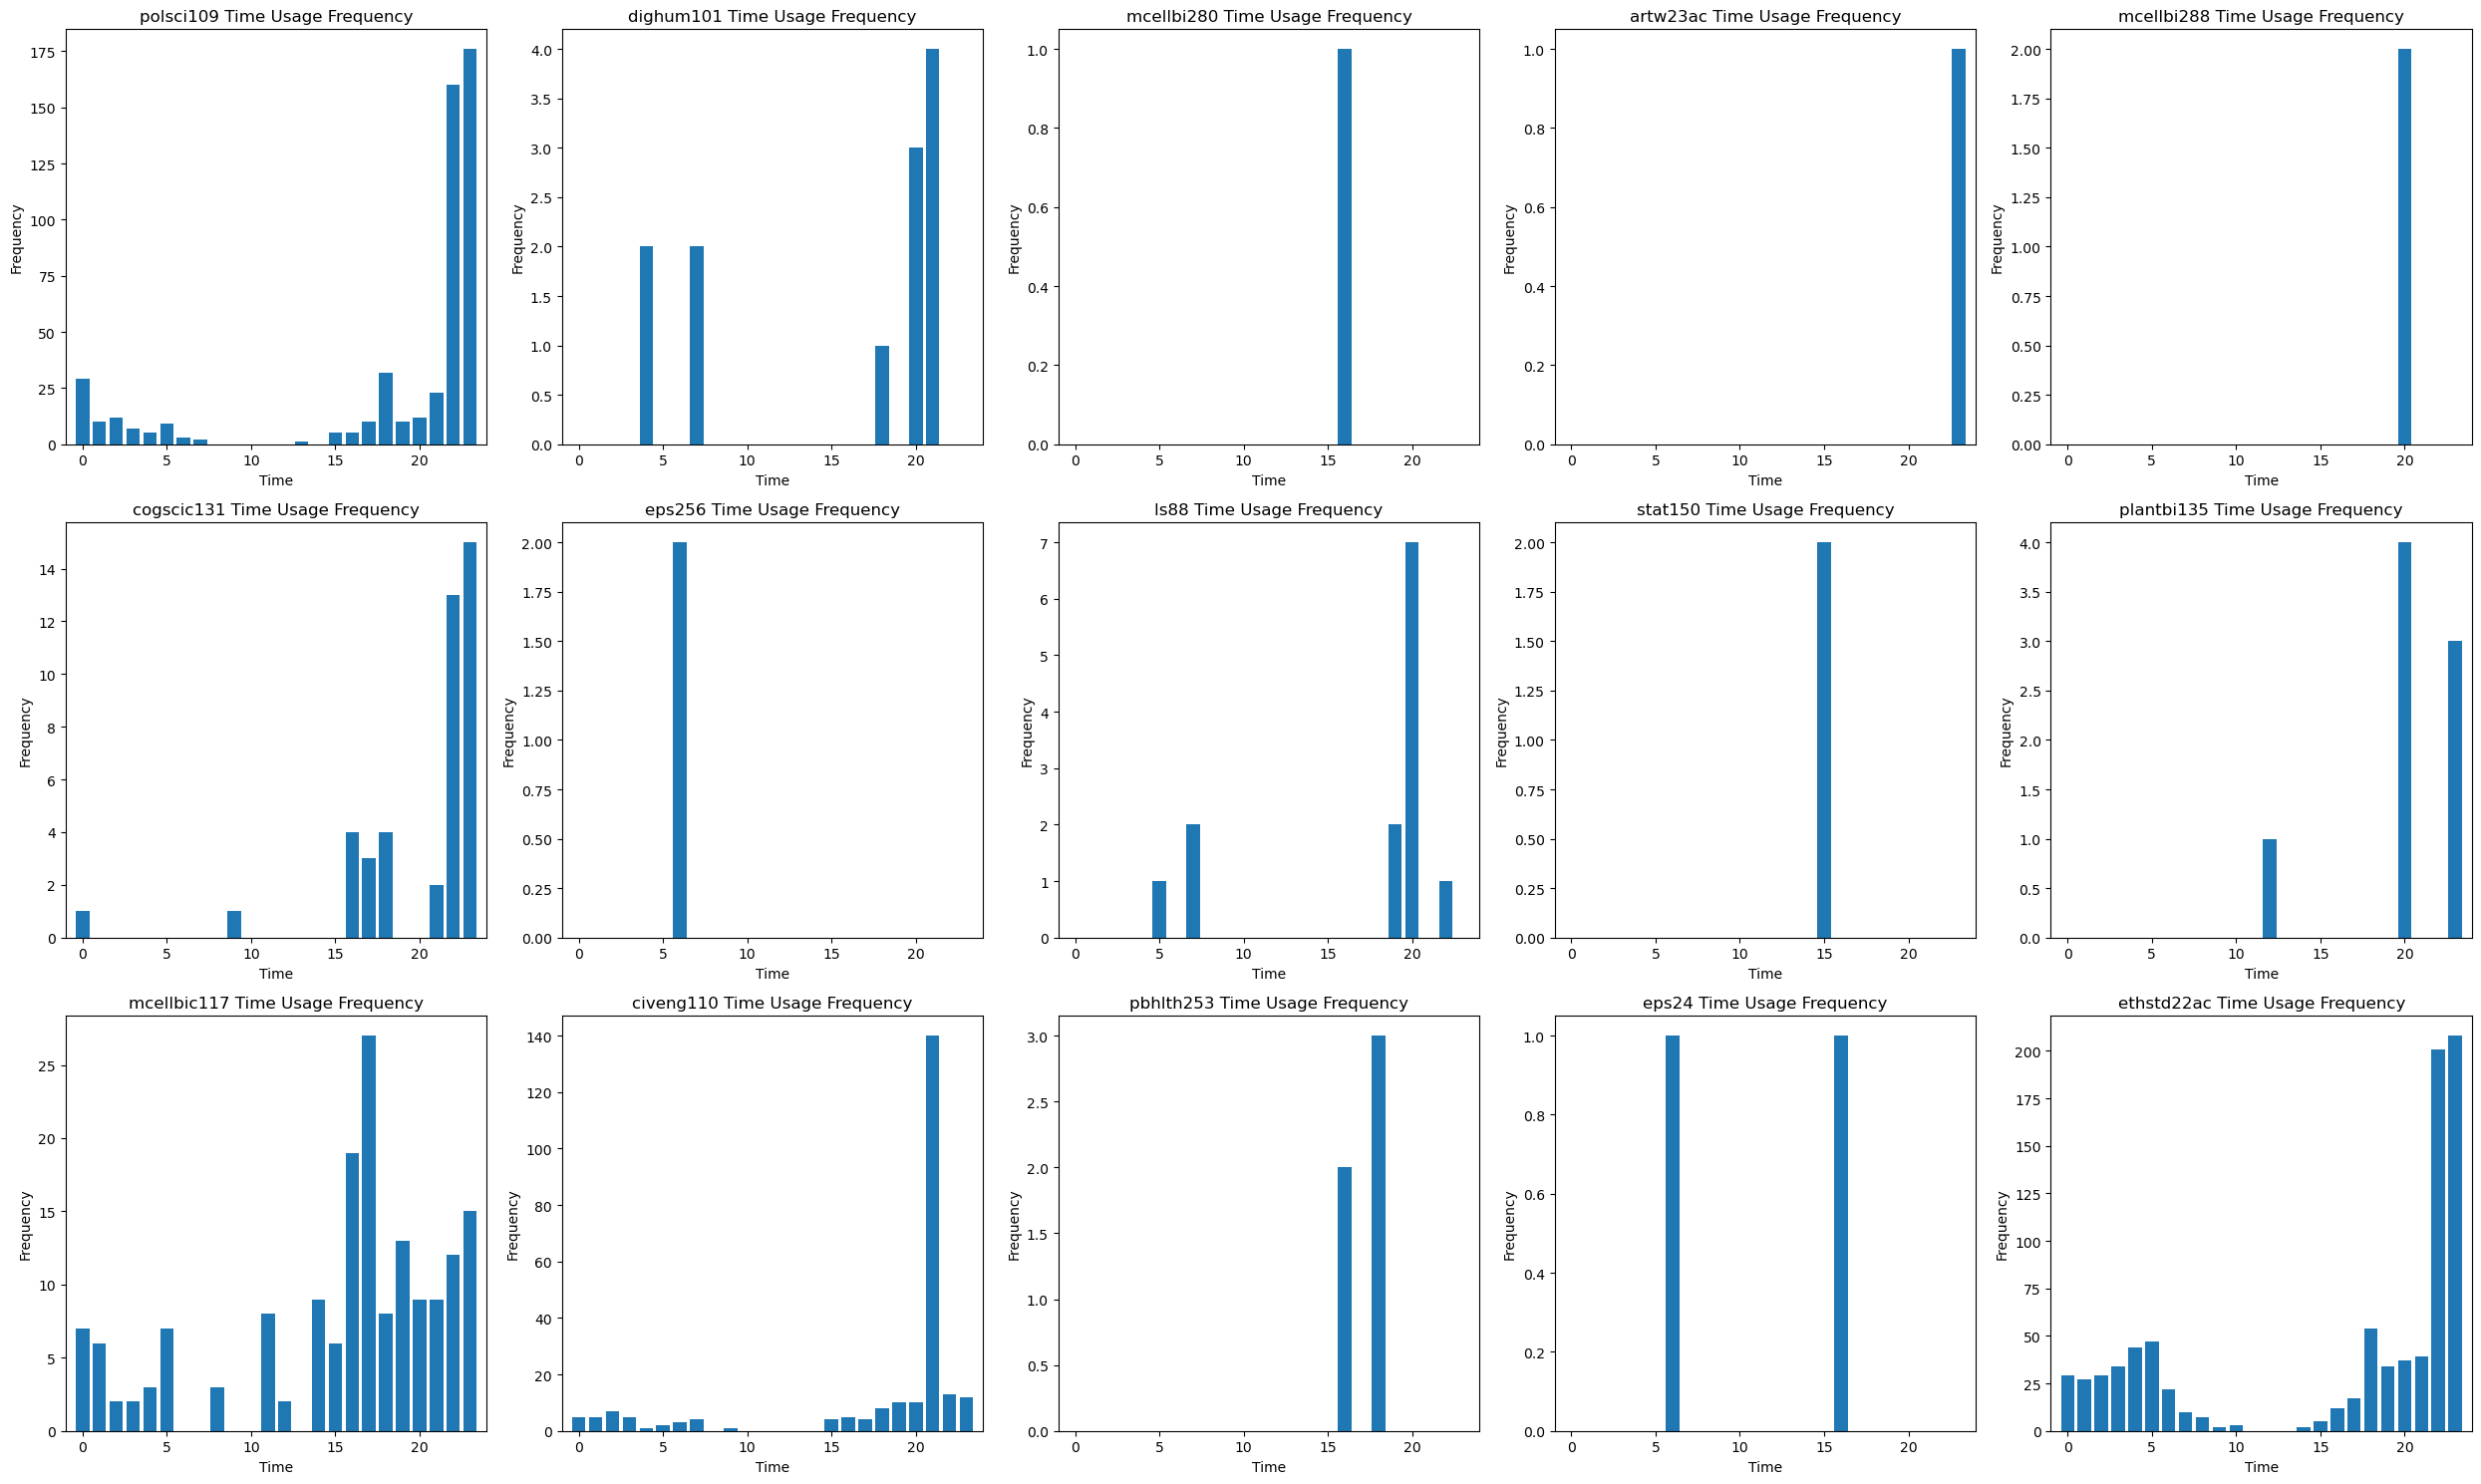

In [41]:
# look at usage time by course 76 - 90
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 15
total_columns = 5
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(25, 15))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+75]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+75]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

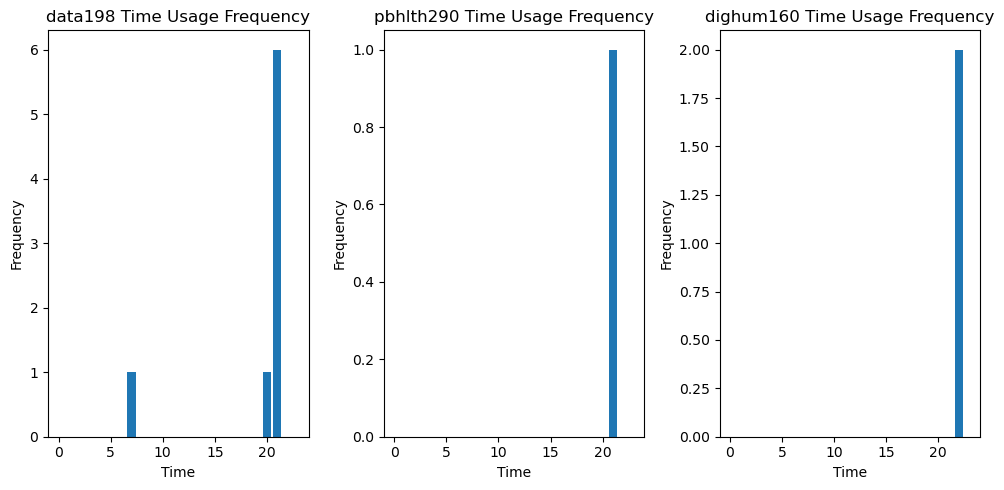

In [42]:
# look at usage time by course 91-83
# length of unique_courses is 93, plotting 15 plots at a time
total_plots = 3
total_columns = 3
total_rows = int(np.ceil(total_plots/total_columns))

fig, axes = plt.subplots(total_rows, total_columns, figsize=(10, 5))
plt.setp(axes, xlim=(-1,24))

for k in range(total_plots):
    course = nbgitpuller_textPayload_df_pull_normal[nbgitpuller_textPayload_df_pull_normal.course == unique_courses[k+90]].reset_index()
    course['timestamp_time'] = pd.to_datetime(course['timestamp_time'], format = '%H:%M:%S.%f')
    course['timestamp_time_hour'] = course['timestamp_time'].apply(lambda x: x.hour)
    courses_time = course.groupby(by = 'timestamp_time_hour').timestamp_time_hour.count()
    ax = axes.flatten()[k] if total_plots > 1 else axes # handles single plot cases
    ax.bar(courses_time.index, courses_time)

    ax.set_title(f'{unique_courses[k+90]} Time Usage Frequency')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

### Non-Github Repos

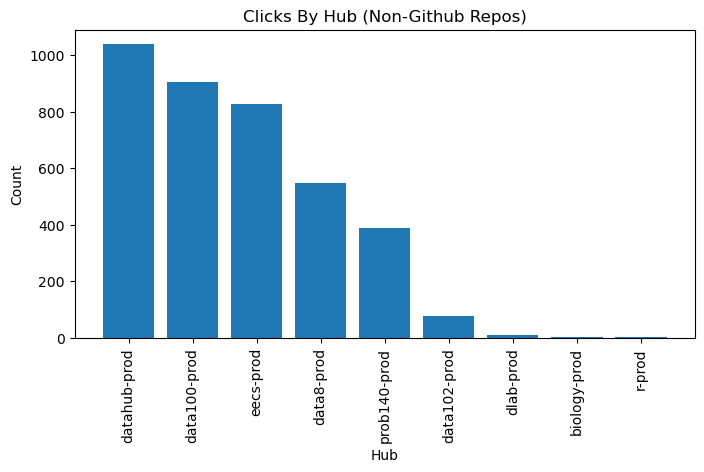

In [43]:
# clicks by hub for abnormal
clicks_by_hub = nbgitpuller_textPayload_df_pull_abnormal.hub.value_counts()
fig = plt.figure(figsize = (8,4))
plt.bar(clicks_by_hub.index, clicks_by_hub)
plt.xlabel('Hub')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.title('Clicks By Hub (Non-Github Repos)');

In [61]:
len(nbgitpuller_textPayload_df_pull.hub.unique())

26

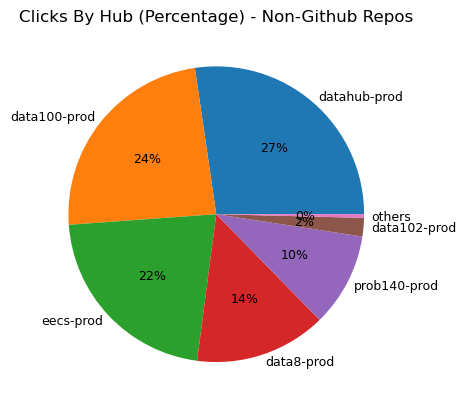

In [44]:
clicks_by_hub_top6 = dict(clicks_by_hub[:6])
clicks_by_hub_top6['others'] = clicks_by_hub[6:].sum()
clicks_by_hub_top6_df = pd.DataFrame(clicks_by_hub_top6.items(), columns = ['hub', 'counts'])
plt.pie(clicks_by_hub_top6_df.counts, labels = clicks_by_hub_top6_df.hub, autopct='%1.0f%%', textprops={'fontsize': 9}, labeldistance= 1.05)
plt.title('Clicks By Hub (Percentage) - Non-Github Repos');

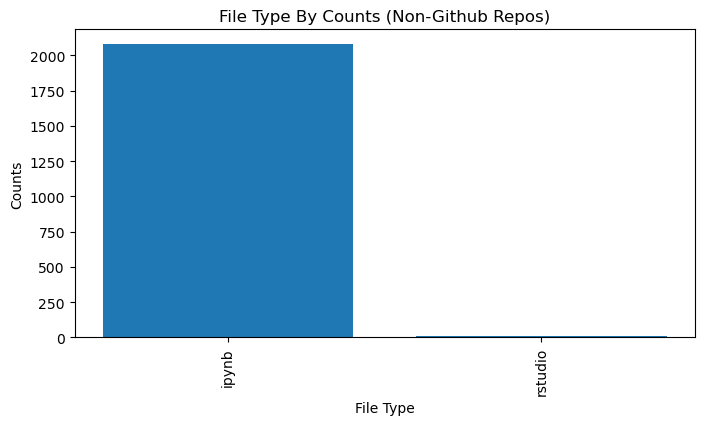

In [45]:
file_types_count = nbgitpuller_textPayload_df_pull_abnormal.file_extension[nbgitpuller_textPayload_df_pull_abnormal.file_extension != 'NaN'].value_counts()
fig = plt.figure(figsize=(8,4))
plt.bar(file_types_count.index, file_types_count)
plt.xticks(rotation=90)
plt.xlabel('File Type')
plt.ylabel('Counts')
plt.title('File Type By Counts (Non-Github Repos)');

In [46]:
# filetypes across hubs
hubs = nbgitpuller_textPayload_df_pull_abnormal.hub.unique()
total_plots = len(hubs)
total_columns = 4
total_rows = math.ceil(total_plots/total_columns)

for k in range(total_plots):
    hub_file_filter_count = nbgitpuller_textPayload_df_pull_abnormal[nbgitpuller_textPayload_df_pull_abnormal.hub == hubs[k]].file_extension.value_counts().tolist()
    hub_file_filter_proportion = nbgitpuller_textPayload_df_pull_abnormal[nbgitpuller_textPayload_df_pull_abnormal.hub == hubs[k]].file_extension.value_counts(normalize = True).mul(100).round(2).tolist()
    hub_file_filter_key = nbgitpuller_textPayload_df_pull_abnormal[nbgitpuller_textPayload_df_pull_abnormal.hub == hubs[k]].file_extension.value_counts().keys().tolist()
    hub_file_filter_df = pd.DataFrame(data = {'file_type': hub_file_filter_key, 'counts': hub_file_filter_count, 'proportions': hub_file_filter_proportion})
    hub_file_filter_df['count_proportion'] = hub_file_filter_df['counts'].astype(str) + ' (' + hub_file_filter_df['proportions'].astype(str) + ')'
    hub_file_filter_df.drop(columns = ['counts', 'proportions'], inplace = True)
    print(hubs[k])
    print(hub_file_filter_df)

# for ax in axes.flatten():
#     if not ax.get_visible():
#         ax.set_axis_off()

datahub-prod
  file_type count_proportion
0     ipynb      985 (94.89)
1       NaN        49 (4.72)
2   rstudio         4 (0.39)
eecs-prod
  file_type count_proportion
0       NaN      810 (97.83)
1     ipynb        18 (2.17)
prob140-prod
  file_type count_proportion
0     ipynb      264 (67.69)
1       NaN      126 (32.31)
dlab-prod
  file_type count_proportion
0       NaN         6 (60.0)
1   rstudio         4 (40.0)
data100-prod
  file_type count_proportion
0       NaN      710 (78.37)
1     ipynb      196 (21.63)
data8-prod
  file_type count_proportion
0     ipynb      547 (100.0)
data102-prod
  file_type count_proportion
0     ipynb       71 (92.21)
1       NaN         6 (7.79)
r-prod
  file_type count_proportion
0   rstudio         1 (50.0)
1       NaN         1 (50.0)
biology-prod
  file_type count_proportion
0       NaN        3 (100.0)


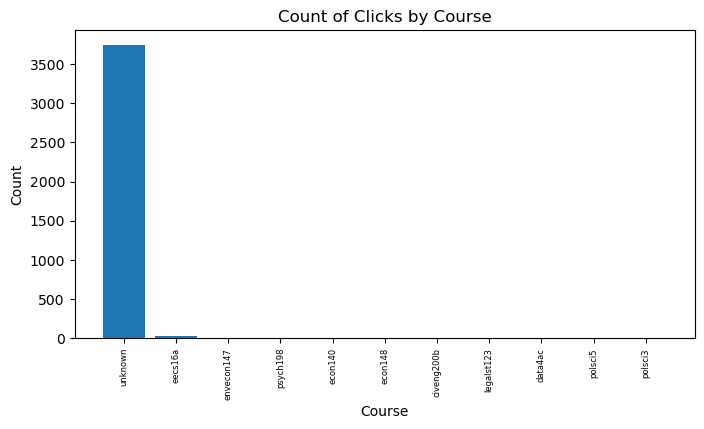

In [47]:
# looking at the classes
course_count = nbgitpuller_textPayload_df_pull_abnormal.course.value_counts()
figure = plt.figure(figsize = (8,4))
plt.bar(course_count.index, course_count)
plt.xticks(rotation = 90, fontsize = 6)
plt.xlabel('Course')
plt.ylabel('Count')
plt.title('Count of Clicks by Course');

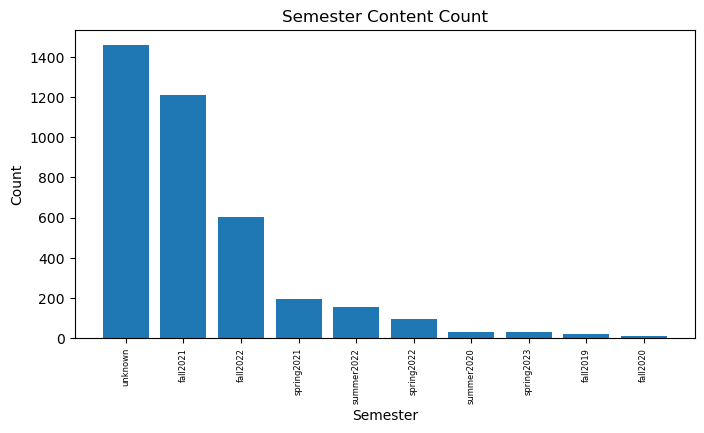

In [48]:
# looking at the semester usage 
sem_count = nbgitpuller_textPayload_df_pull_abnormal.semester.value_counts()
figure = plt.figure(figsize = (8,4))
plt.bar(sem_count.index, sem_count)
plt.xticks(rotation = 90, fontsize = 6)
plt.xlabel('Semester')
plt.ylabel('Count')
plt.title('Semester Content Count');